# 1. Overview


The project aimed to assist investors in understanding stock trends by analyzing time-series data of ASML’s stock performance. As a third-party consulting firm, we specialize in helping investors and companies gain insights into market behavior, enabling them to make informed decisions based on data-driven forecasts. For this project, we sourced daily stock price data from Yahoo Finance, covering ASML stock prices from January 1, 2018, to November 15, 2024. The daily data was aggregated into weekly averages, resulting in a weekly time-series dataset containing cxx records.

Our business objective was to predict the future trend of ASML’s stock prices for a 2-week horizon, as this information is crucial for investors looking to optimize their portfolio strategies. The dataset was split into training and testing sets based on the variable test_weeks, which included the last 12 weeks of data for testing, while the rest was used for training. Preprocessing techniques such as normalization, handling missing values, and data smoothing were applied to prepare the data for analysis.

We tested multiple forecasting models, including SARIMAX, Prophet, XGBoost, Random Forest, Naive, and ETS (additive and multiplicative). Prophet was selected as the final model based on its superior performance in terms of root mean square error (RMSE) and mean absolute percentage error (MAPE). After optimization, the model achieved a MAPE of 3XX% on the test set.

The final model was deployed to provide reliable forecasts for the next two weeks, offering valuable insights to investors aiming to anticipate stock trends and make strategic decisions.

# 2. Business Understanding

We are a third-party consulting firm specializing in providing actionable insights to investors seeking to optimize their portfolio strategies through data-driven predictions of stock trends. For this project, we assist investors by analyzing historical stock performance to predict the future movement of ASML’s stock price. Our goal is to provide investors with a reliable forecast that can support their decision-making process when managing their investments.

Our core offering involves analyzing time-series data of ASML’s stock prices, sourced daily from Yahoo Finance, covering the period from January 1, 2018, to November 15, 2024. The daily stock price data is aggregated into weekly averages to facilitate better analysis and smoother trends. This aggregation results in a time-series dataset with weekly records, enabling us to track how ASML’s stock has performed over time.

The primary business objective of this project is to predict ASML’s stock price trend for the next two weeks. This is essential for investors who need to anticipate market behavior and adjust their portfolios accordingly. To achieve this, we preprocess the data to handle missing values, normalize the data, and smooth any noise that could interfere with forecasting accuracy. We then split the dataset into training and testing sets, with the last 12 weeks of data reserved for testing the predictive model.

We apply various forecasting techniques to predict future stock prices, including SARIMAX, Prophet, XGBoost, Random Forest, Naive, and ETS models. Each of these models is evaluated based on performance metrics such as Root Mean Square Error (RMSE) and Mean Absolute Percentage Error (MAPE). After comparing these models, Prophet was selected as the final model due to its superior performance in minimizing RMSE and MAPE values, achieving a MAPE of 3XX% on the test set.

The final forecast model was deployed to provide reliable predictions of ASML’s stock price trend for the next two weeks. These predictions are crucial for investors, as they enable them to make informed decisions about whether to buy, sell, or hold ASML stock. Ultimately, our insights help investors optimize their portfolio strategies by providing actionable forecasts of stock performance.

# 3. Data Understanding

## 3.1 Data Description

The dataset used in this project consists of daily stock price data for ASML, sourced from Yahoo Finance, covering the period from January 1, 2018, to November 15, 2024. The dataset includes the following columns: Date, Open, High, Low, Close, Volume, Dividends, and Stock Splits. To facilitate time-series analysis, the daily data was aggregated into weekly averages, resulting in a time-series dataset with 359 weekly records. The data was then preprocessed to handle missing values, normalize the stock prices, and smooth out fluctuations that could affect forecasting accuracy. This dataset serves as a comprehensive foundation for predicting ASML’s future stock price trends, based on its historical market performance.

## 3.2 Import necessary libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import joblib
import json
import pickle
import sys
import os
import yfinance as yf
from datetime import datetime, timedelta

# Time-series and Forecasting
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

# Machine Learning and Modeling
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet

# Metrics and Evaluation
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Suppress Warnings and Logs
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
logging.getLogger('prophet').setLevel(logging.ERROR)

# Disable Logs from Prophet
logging.getLogger('cmdstanpy').disabled = True

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 3.3 Define Global Variables

In [2]:
# Company-related settings
company_name = 'ASML'  # Replace 'ASML' with any other company ticker (e.g., 'AAPL' for Apple)
company_tickers = {
    'CZMWY': 'Carl_Zeiss_Meditec',
    'LRCX': 'Lam_Research_Corporation',
    'TOELY': 'Tokyo_Electron_Limited',
#     'AMAT':'Applied_Materials',
#     'MKSI':'MKS_Instruments'
#     'TSM': 'Taiwan_Semiconductor_Manufacturing_Company',
#     '005930.KS': 'Samsung_Electronics',
#     'INTC': 'Intel_Corporation'
}

# Data paths for ASML
start_date = '2018-01-01'
input_data_asml = 'data/weekly_data_asml.csv'
output_data_asml = 'data/weekly_data_asml.csv'  # General output path for ASML data
output_model_path_asml = 'models/prophet_simple_asml_model.pkl'
output_best_variables_path_asml = 'data/best_prophet_variables_asml.json'
input_model_path_train = 'models/prophet_asml_combination_with_suppliers_train.pkl'


# Data paths for suppliers
input_data_suppliers = 'data/weekly_data_suppliers.csv'
output_data_suppliers = 'data/weekly_data_suppliers.csv'  # General output path for suppliers data
output_best_variables_path_suppliers = 'data/best_prophet_variables_with_suppliers.json'

# Combined data paths
input_data_combination = 'data/weekly_data_combination.csv'
output_data_combination = 'data/weekly_data_combination.csv'
output_model_path_combination = 'models/prophet_asml_combination_with_suppliers.pkl'
output_best_params_path_combination = 'data/best_prophet_params.json'
output_regressors_path_combination = 'data/best_regressors.json'

# Shared paths for start data and test weeks
output_start_data_and_test_weeks_path = 'data/start_data_and_test_weeks.pkl'

# Paths for best variables and models (combination and specific to ASML or suppliers)
output_best_variables_path_combination = 'data/best_prophet_variables_with_suppliers.json'
output_model_path_asml_suppliers = 'models/prophet_asml_combination_with_suppliers.pkl'

# Additional configurations
test_weeks = 12
future_weeks = 2

# Paths for parameter and regressor files
input_best_params_path = 'data/best_prophet_params.json'
input_regressors_path = 'data/best_regressors.json'

## 3.5 Functions

In [3]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [4]:
# Groupby daily, weekly, and monthly
def plot_stock_by_period(historical_data:pd.DataFrame, company_name:str):
    """
    Input: 
    - historical_data: DataFrame containing stock data with 'Date' and 'Close' columns.
    - company_name: String representing the name of the company.

    Output: 
    - Three line plots showing daily, weekly, and monthly average closing prices.
    - Prints the count of data points for each group (daily, weekly, and monthly).

    Logic: 
    - The function resamples the stock data by day, week, and month, computes the average closing price, 
      and generates line plots using Matplotlib for each resampled dataset.
    """

    # Convert 'Date' column to datetime if not already
    historical_data['Date'] = pd.to_datetime(historical_data['Date'])

    # Set 'Date' as the DataFrame index
    historical_data.set_index('Date', inplace=True)

    # Group by different periods
    daily_data = historical_data.resample('D').median()
    weekly_data = historical_data.resample('W').median()
    monthly_data = historical_data.resample('M').median()

    # Print the number of data points for each period
    print(f"Number of daily data points: {daily_data.shape[0]}")
    print(f"Number of weekly data points: {weekly_data.shape[0]}")
    print(f"Number of monthly data points: {monthly_data.shape[0]}")

    # Convert 'Date' and 'Close' columns to NumPy arrays for matplotlib compatibility
    daily_dates = daily_data.index.to_numpy()
    daily_close_prices = daily_data['Close'].to_numpy()

    weekly_dates = weekly_data.index.to_numpy()
    weekly_close_prices = weekly_data['Close'].to_numpy()

    monthly_dates = monthly_data.index.to_numpy()
    monthly_close_prices = monthly_data['Close'].to_numpy()

    # Plot daily data
    plt.figure(figsize=(10, 6))
    plt.plot(daily_dates, daily_close_prices, label='Daily Closing Price', color='blue')
    plt.title(f'{company_name} - Daily Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot weekly data
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_dates, weekly_close_prices, label='Weekly Closing Price', color='green')
    plt.title(f'{company_name} - Weekly Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot monthly data
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_dates, monthly_close_prices, label='Monthly Closing Price', color='red')
    plt.title(f'{company_name} - Monthly Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
def create_daily_date_list(start_date:str, end_date:str)->list:
    """
    Input: start_date and end_date as strings in "YYYY-MM-DD" format
    Output: List of dates between start_date and end_date in "YYYY-MM-DD" format
    Logic: Iterates from start_date to end_date, adding each day to the list in "YYYY-MM-DD" format
    """

    
    # Parse the start and end dates from string format to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Initialize an empty list to store the dates
    date_list = []
    
    # Generate dates by iterating from start to end date with daily frequency
    current_date = start
    while current_date <= end:
        date_list.append(current_date.strftime("%Y-%m-%d"))  # Append date as a string in 'YYYY-MM-DD' format
        current_date += timedelta(days=1)  # Move to the next day

    return date_list

In [6]:
def get_last_friday():
    """
    Input: No arguments; the function uses the current date as the starting point.
    Output: Returns `end_date` as a string formatted as `YYYY-MM-DD`, representing the last Friday's date.
    Logic: Calculate the number of days back to the last Friday.    
    
    """
    today = datetime.today()
    # Calculate the number of days back to the last Friday
    days_back = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_back)
    end_date = last_friday.strftime("%Y-%m-%d")
    return end_date


end_date = get_last_friday()

In [7]:
# Feature engineering for time series
def create_features(df):
    """
    Create time-based features for time series data.
    
    Input:
    - df: DataFrame with a datetime index and a single column for the target variable.

    Output:
    - df: DataFrame with added columns for year, month, week of the year, quarter, and cuatrimestre.

    Logic:
    - Extracts the 'year', 'month', 'week_of_year', 'quarter', and 'cuatrimestre' 
      from the datetime index to create additional time-based features.
    """
    df = df.copy()  # Create a copy of the DataFrame to avoid the warning
    df['year'] = df.index.year            # Extract year from the date
    df['month'] = df.index.month          # Extract month from the date
    df['week_of_year'] = df.index.isocalendar().week  # Extract week of the year from the date
    df['quarter'] = df.index.quarter      # Extract quarter from the date
    df['cuatrimestre'] = ((df.index.month - 1) // 4) + 1  # Calculate cuatrimestre (four-month period)
    return df

In [8]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [9]:
def plot_closing_prices(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(data.index)
    close_prices = np.array(data[close_column])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()


In [10]:
def plot_stock_with_multiple_boxplots(data: pd.DataFrame, close_column: str, company_name: str) -> pd.DataFrame:
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """
    # Ensure 'Date' column is in datetime format only if it is not already
    if not pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = pd.to_datetime(data['Date'])

    # Extract additional time period information
    data['Weekday'] = data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    data['Month'] = data['Date'].dt.month      # Month (1=January, 12=December)
    data['Quarter'] = data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    return data

In [11]:
# Function to add exogenous variables to the future_dataframe
def add_exogenous_variables(weekly_data):
    """
    Input: future_df (DataFrame) - A DataFrame containing future dates in the 'ds' column.
    Output: future_df (DataFrame) - The same DataFrame with added binary columns for each exogenous event.
    Logic: Adds binary indicators for each specified geopolitical and economic event based on predefined date ranges.
    """
    
    # Define the date ranges for each exogenous event
    covid_start = '2020-01-01'
    covid_end = '2022-12-31'

    geopolitical_tension_start = '2022-02-01'
    geopolitical_tension_end = '2025-12-31'

    trade_sanctions_start = '2018-07-01'
    trade_sanctions_end = '2029-12-31'

    tech_regulation_start = '2020-06-01'
    tech_regulation_end = '2029-12-31'

    new_product_launch_start = '2023-12-01'
    new_product_launch_end = '2025-12-31'

    israel_gaza_conflict_start = '2023-10-07'
    israel_gaza_conflict_end = '2025-12-31'

    # COVID Period
    weekly_data['COVID_Period'] = ((weekly_data.index >= covid_start) & 
                                 (weekly_data.index <= covid_end)).astype(int)
    
    # Geopolitical Tensions (Ukraine Conflict)
    weekly_data['Geopolitical_Tension'] = ((weekly_data.index >= geopolitical_tension_start) & 
                                         (weekly_data.index <= geopolitical_tension_end)).astype(int)
    
    # US-China Trade War
    weekly_data['Trade_Sanctions'] = ((weekly_data.index >= trade_sanctions_start) & 
                                    (weekly_data.index <= trade_sanctions_end)).astype(int)
    
    # Tech Regulation (Export Restrictions)
    weekly_data['Tech_Regulation'] = ((weekly_data.index >= tech_regulation_start) & 
                                    (weekly_data.index <= tech_regulation_end)).astype(int)
    
    # New EUV Machine Launch (TWINSCAN EXE:5000)
    weekly_data['New_Product_Launch'] = ((weekly_data.index >= new_product_launch_start) & 
                                       (weekly_data.index <= new_product_launch_end)).astype(int)
    
    # Israel-Gaza Conflict
    weekly_data['Israel_Gaza_Conflict'] = ((weekly_data.index >= israel_gaza_conflict_start) & 
                                         (weekly_data.index <= israel_gaza_conflict_end)).astype(int)

## 3.3 Data Understanding

### 3.3.1 Exploratory Analysis

For a complete exploratory analysis of the ASML stock time series, please refer to notebook [Go to Notebook 01_data_understanding.ipynb](01_data_understanding.ipynb).

#### 3.3.1.1 Looking at the dataset

We are going to load the data using the function get_historical_data

In [12]:
# Call the function get_historical_data
historical_data = get_historical_data(company_name, start_date, end_date)

# Convert 'Date' column to datetime format and keep only the date (without time)
historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

historical_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02,162.386561,165.836829,162.237356,165.734253,818600,0.0,0.0
1,2018-01-03,165.734291,167.459432,165.687662,166.993179,1054200,0.0,0.0
2,2018-01-04,168.308045,169.501652,167.291602,168.550491,915600,0.0,0.0
3,2018-01-05,168.634403,171.068245,168.550481,170.527390,516100,0.0,0.0
4,2018-01-08,170.825774,172.010060,170.471417,171.422577,763900,0.0,0.0
...,...,...,...,...,...,...,...,...
1730,2024-11-15,678.359985,679.880005,657.520020,658.630005,3063200,0.0,0.0
1731,2024-11-18,651.070007,668.859985,648.000000,665.229980,2012600,0.0,0.0
1732,2024-11-19,662.820007,671.409973,653.469971,662.159973,1640700,0.0,0.0
1733,2024-11-20,656.530029,658.479980,645.450012,658.429993,1677800,0.0,0.0


Now let's plot the stock data

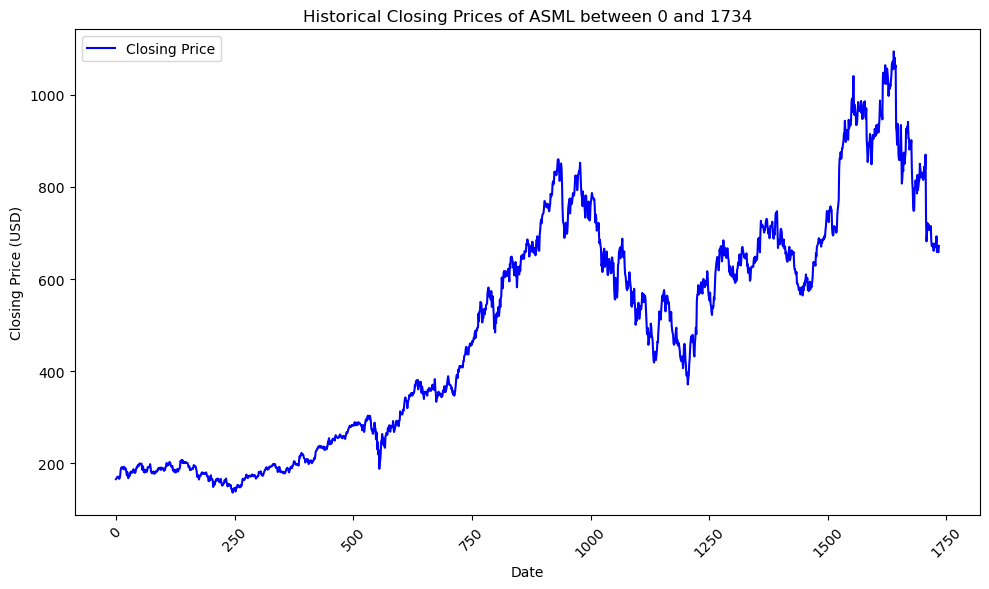

In [13]:
plot_closing_prices(historical_data, 'Close', company_name)

#### 3.3.1.2 Checking for duplicate values

In [14]:
historical_data.duplicated().sum()

0

There are no duplicated values. So we can continue

#### 3.3.1.3 Checking for missing dates

In [15]:
(historical_data.isna().sum()/len(historical_data))*100

Date            0.0
Open            0.0
High            0.0
Low             0.0
Close           0.0
Volume          0.0
Dividends       0.0
Stock Splits    0.0
dtype: float64

As we can see there aren't any null values

Let's check the dates of the data

In [16]:
dates = create_daily_date_list(start_date, end_date)

date_range = pd.DataFrame(dates, columns=["Date"]) 

date_range

,Date
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
2513,2024-11-18
2514,2024-11-19
2515,2024-11-20
2516,2024-11-21


In [17]:
# Ensure the 'Date' columns in both DataFrames are in datetime format for merging
historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date
date_range['Date'] = pd.to_datetime(date_range['Date']).dt.date

# Perform the merge on the 'Date' column
merged_data = pd.merge(date_range, historical_data, on='Date', how='left')

merged_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,162.386561,165.836829,162.237356,165.734253,818600.0,0.0,0.0
2,2018-01-03,165.734291,167.459432,165.687662,166.993179,1054200.0,0.0,0.0
3,2018-01-04,168.308045,169.501652,167.291602,168.550491,915600.0,0.0,0.0
4,2018-01-05,168.634403,171.068245,168.550481,170.527390,516100.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2513,2024-11-18,651.070007,668.859985,648.000000,665.229980,2012600.0,0.0,0.0
2514,2024-11-19,662.820007,671.409973,653.469971,662.159973,1640700.0,0.0,0.0
2515,2024-11-20,656.530029,658.479980,645.450012,658.429993,1677800.0,0.0,0.0
2516,2024-11-21,653.919983,673.059998,649.020020,672.159973,2859000.0,0.0,0.0


We can see that there are null values because these are weekend dates. We are going to fill these null values doing a forward fill.

In [18]:
# Perform a forward fill to fill NaN values with the previous valid value
historical_data_complete = merged_data.fillna(method='ffill')

# Drop rows with NaN
historical_data_complete = historical_data_complete.dropna().reset_index(drop=True)

# Display the forward-filled DataFrame
historical_data_complete

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02,162.386561,165.836829,162.237356,165.734253,818600.0,0.0,0.0
1,2018-01-03,165.734291,167.459432,165.687662,166.993179,1054200.0,0.0,0.0
2,2018-01-04,168.308045,169.501652,167.291602,168.550491,915600.0,0.0,0.0
3,2018-01-05,168.634403,171.068245,168.550481,170.527390,516100.0,0.0,0.0
4,2018-01-06,168.634403,171.068245,168.550481,170.527390,516100.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2512,2024-11-18,651.070007,668.859985,648.000000,665.229980,2012600.0,0.0,0.0
2513,2024-11-19,662.820007,671.409973,653.469971,662.159973,1640700.0,0.0,0.0
2514,2024-11-20,656.530029,658.479980,645.450012,658.429993,1677800.0,0.0,0.0
2515,2024-11-21,653.919983,673.059998,649.020020,672.159973,2859000.0,0.0,0.0


We will just keep columns: Data and Close

In [19]:
# Keep only the 'Date' and 'Close' columns
historical_data_complete = historical_data_complete[['Date', 'Close']]

# Display the resulting DataFrame
historical_data_complete

,Date,Close
0,2018-01-02,165.734253
1,2018-01-03,166.993179
2,2018-01-04,168.550491
3,2018-01-05,170.527390
4,2018-01-06,170.527390
...,...,...
2512,2024-11-18,665.229980
2513,2024-11-19,662.159973
2514,2024-11-20,658.429993
2515,2024-11-21,672.159973


### 3.3.2 Exploratory Analysis

#### 3.3.2.1 Looking at seasonality

historical_data_complete.reset_index(inplace=True)

<Figure size 1200x800 with 0 Axes>

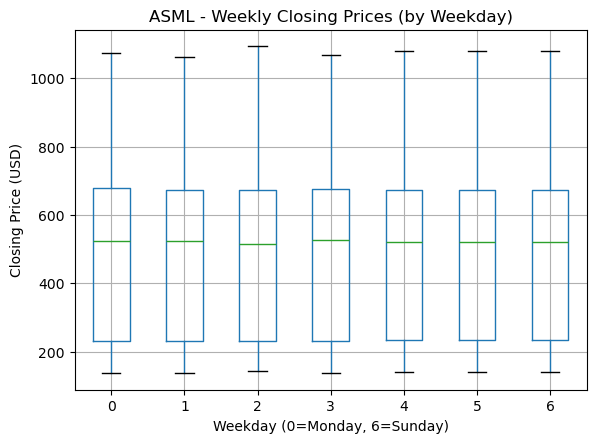

<Figure size 1200x800 with 0 Axes>

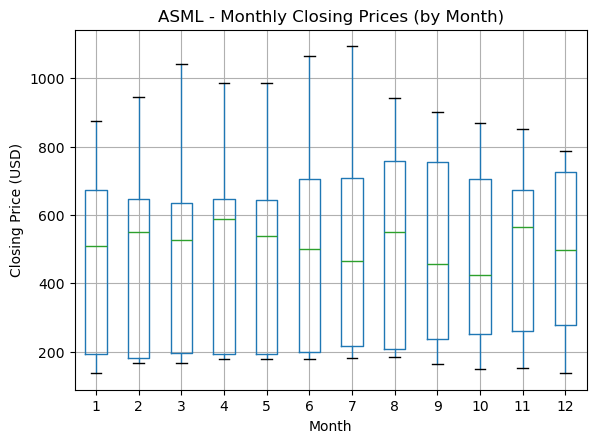

<Figure size 1200x800 with 0 Axes>

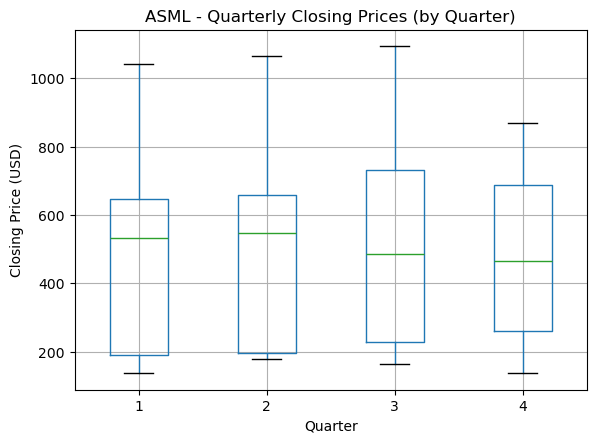

In [20]:
plot_stock_with_multiple_boxplots(historical_data_complete, 'Close', company_name);

With the results above, we cannot determine if there is any clear seasonality. 

#### 3.3.2.2 Choosing the time series of our dataset

We are going to transform the data. Based on out business case we are going to choose the weekly data because we want to give weekly predictions.

We are going to eliminate the week end date to avoid distorsions on the weekly data calculus

In [21]:
# Convert 'Date' column to datetime
historical_data_complete['Date'] = pd.to_datetime(historical_data_complete['Date'])

# Set the 'Date' column as the index
historical_data_complete.set_index('Date', inplace=True)

# Filter the dataframe to exclude weekends
historical_data_complete = historical_data_complete[historical_data_complete.index.weekday < 5]

In [22]:
# Set 'Date' as the DataFrame index
# historical_data_complete.set_index('Date', inplace=True)
weekly_data = historical_data_complete.resample('W').median()

#### 3.3.2.3 Further EDA

**Seasonal-Trend-Loess Decomposition (STL)**

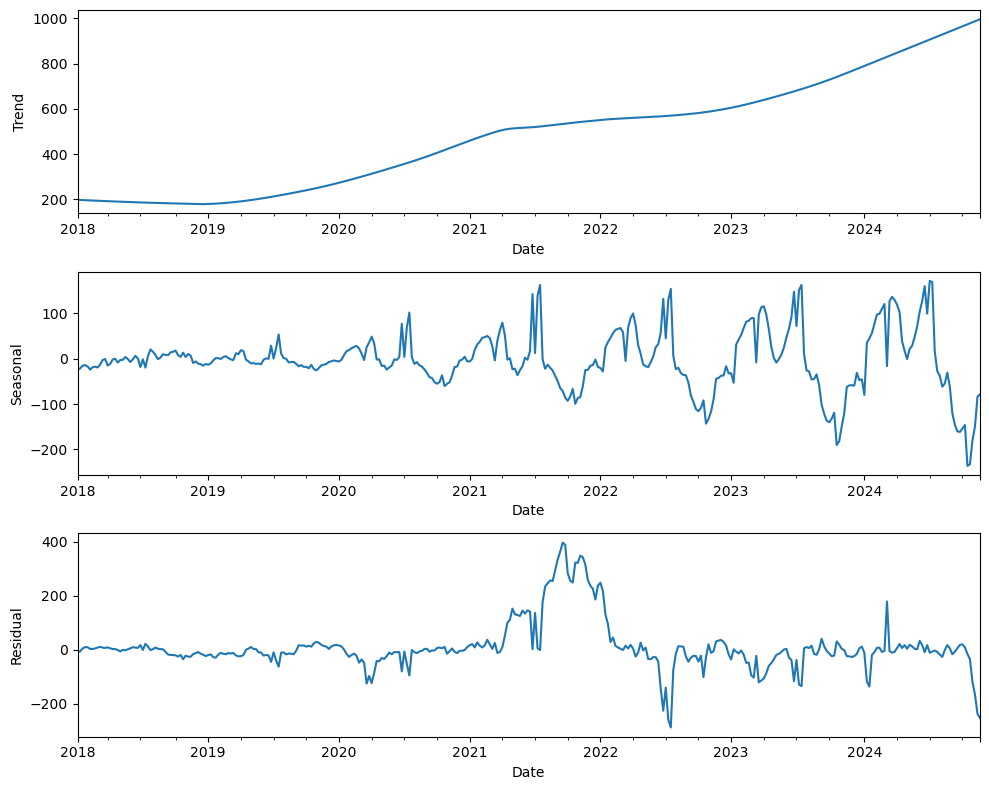

In [23]:
# Perform STL decomposition on the 'Close' prices
stl = STL(weekly_data['Close'], period=52, robust=True)
result = stl.fit()

# Plot the decomposed components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
result.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
result.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
result.resid.plot(ax=ax3)
ax3.set_ylabel('Residual')
plt.tight_layout()
plt.show()

The STL decomposition shown in the images provides valuable insights into the stock's time series data.

1. **Trend Component**: The trend shows a steady and accelerating increase in the stock price over time, particularly after 2019. The sharp rise starting around 2020 indicates a significant upward movement, reflecting overall growth in the stock's value.

2. **Seasonal Component**: The seasonal fluctuations become more pronounced after 2019, indicating increased volatility in the stock price. The pattern of these fluctuations is relatively stable until 2019, after which the amplitude increases. This could suggest stronger cyclical patterns or market reactions during this period.

3. **Residual Component**: The residual plot highlights that the deviations from the trend and seasonality were relatively low and stable up until 2020. However, starting in 2020, the residuals become much more volatile, with significant fluctuations. This indicates that there were external factors or events during and after 2020 that caused irregularities and deviations from the expected trend and seasonal patterns, such as market disruptions or other unpredictable events.

In conclusion, while the stock price follows a clear upward trend, both seasonality and residual volatility increase significantly after 2020, indicating a period of heightened uncertainty or external shocks affecting the stock's behavior. This could align with broader market or global events, such as the COVID-19 pandemic.

**Distribution of Returns**

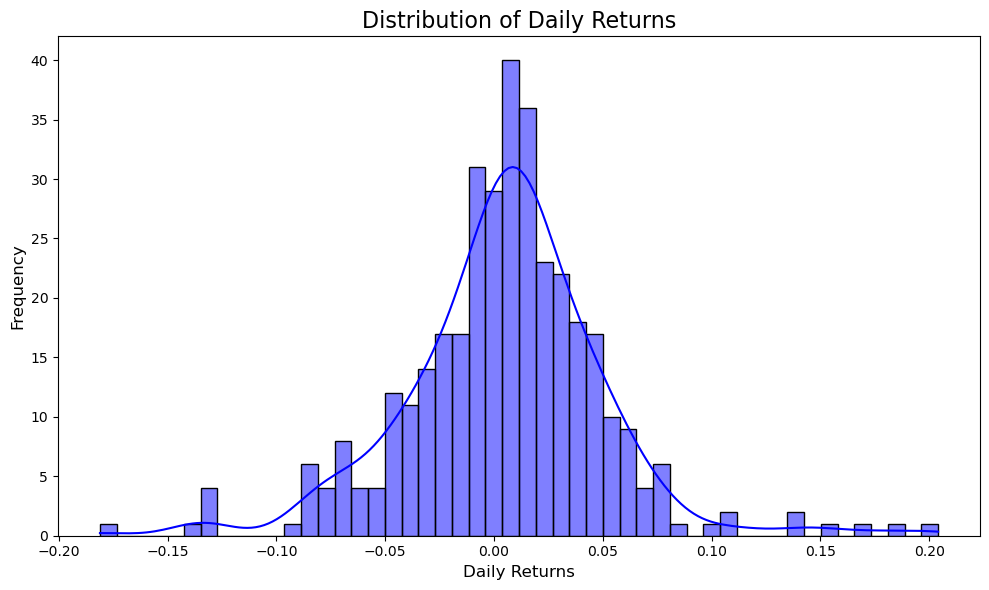

In [24]:
# Step 1: Calculate daily returns
# The pct_change() function calculates the percentage change between the current and prior element.
# This will give us the daily returns as a percentage change of closing prices.
weekly_data['Returns'] = weekly_data['Close'].pct_change()

# Step 2: Drop NaN values that appear after the pct_change() calculation
# NaN values result from the first row since there is no previous data point to compare with.
weekly_data.dropna(subset=['Returns'], inplace=True)

# Step 3: Plotting the distribution of daily returns using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(weekly_data['Returns'], bins=50, kde=True, color='blue')

# Adding titles and labels
plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Returns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

The distribution of daily returns shows a normal-like shape centered around zero, indicating that most returns are close to neutral. However, there is a slight positive skew, suggesting that small positive returns are more frequent than negative ones. The long right tail highlights the occurrence of occasional large positive returns, while the left tail shows some infrequent but larger negative returns. This pattern suggests that the stock typically experiences small, stable gains with occasional volatile movements. Investors should be aware of both the potential for moderate losses and occasional larger gains.

The following EDA studies contain only the conclusions of ASML. Additionally, we performed:

- Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
- Rolling Statistics
- Outlier Detection
- Correlation with External Factors

Creating the DataFrame of ASML's stock after the EDA

In [25]:
# We just want the "Close" column
weekly_data_asml = weekly_data[['Close']]

In [26]:
weekly_data_asml

,Close
Date,
2018-01-14,168.662354
2018-01-21,185.736526
2018-01-28,191.564697
2018-02-04,187.825363
2018-02-11,174.080215
...,...
2024-10-27,710.037903
2024-11-03,683.830017
2024-11-10,671.159973


## 3.4 Forecasting

For a complete exploratory analysis of the ASML stock time series, please refer to notebook [Go to Notebook 02_forecasting.ipynb](02_forecasting.ipynb).

In [27]:
# Explicitly set the frequency of the Date index
weekly_data_asml = weekly_data_asml.asfreq('W')

# Create a copy of weekly_data_asml as weekly_data
weekly_data = weekly_data_asml.copy()

weekly_data.head()

,Close
Date,
2018-01-14,168.662354
2018-01-21,185.736526
2018-01-28,191.564697
2018-02-04,187.825363
2018-02-11,174.080215


In [28]:
# Load the variables using pickle
with open(output_start_data_and_test_weeks_path, 'rb') as f:
    variables = pickle.load(f)

# Extract the variables
start_date = variables['start_date']
test_weeks = variables['test_weeks']

### 3.4.1 Train test split

In [29]:
# For train data
train_data = weekly_data[:-test_weeks]

# For test data
test_data = weekly_data[-test_weeks:]

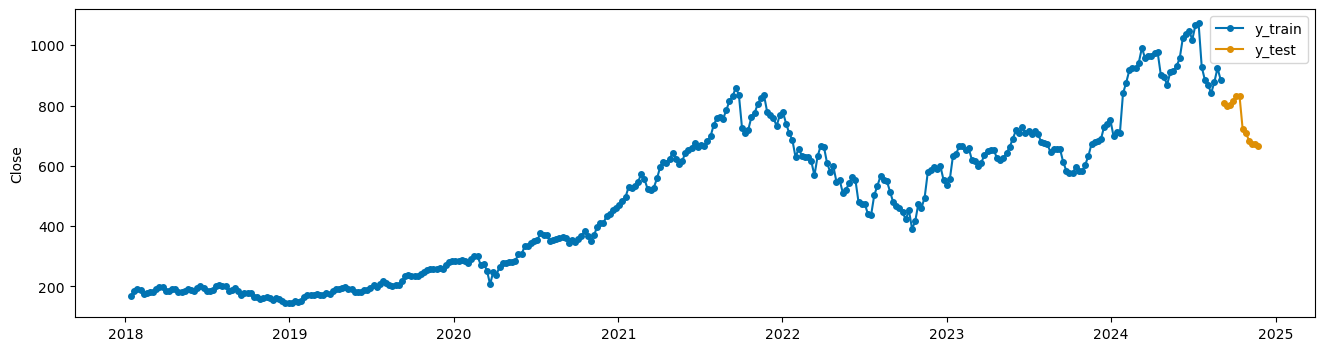

In [30]:
plot_series(train_data, test_data, labels=["y_train", "y_test"]);

### 3.4.2 Creating the baseline of the time series model

**Naive Forecaster**


MAPE_NAIVE:  17.949684134212966
RMSE_NAIVE:  165.51306405995834


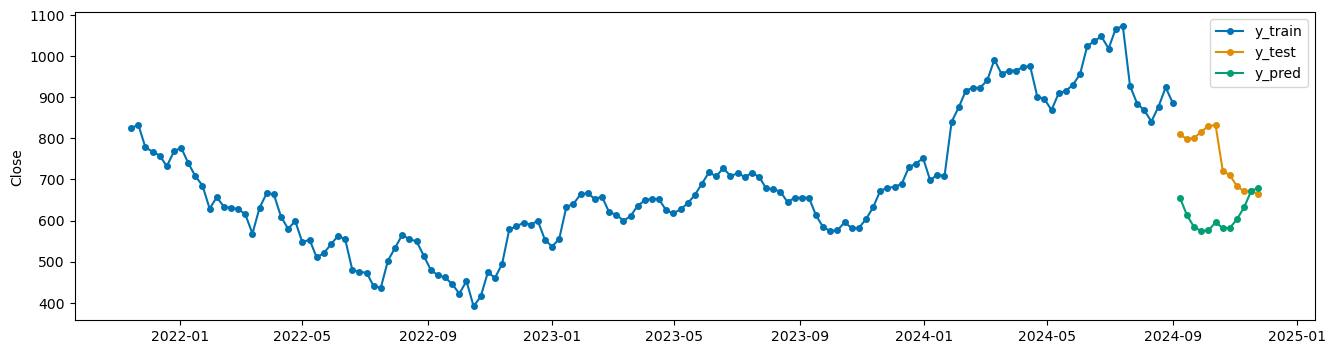

In [31]:
# Initialize the Naive Forecaster (strategy = 'last' means it will use the last value)
naive_forecaster = NaiveForecaster(strategy="last", sp=52)

# Fit the model to the training data
naive_forecaster.fit(train_data)

# Make predictions on the test set
y_pred_naive = naive_forecaster.predict(fh=[i+1 for i in range(len(test_data))])

# Plot the training, test data, and predictions
plot_series(train_data[200:], test_data, y_pred_naive, labels=["y_train", "y_test", "y_pred"]);

print()

# Now we are going to calculate the metrics of the model. The RMSE and the MAPE
mape_naive = mean_absolute_percentage_error(test_data, y_pred_naive) * 100
print("MAPE_NAIVE: ", mape_naive)

rmse_naive = root_mean_squared_error(test_data, y_pred_naive)
print("RMSE_NAIVE: ", rmse_naive)

**ETS**

Initialize the ETS model with additive trend and seasonality 'seasonal_periods' should be set based on the periodicity of the data


MAPE_ETS_ADD:  18.548496558535902
RMSE_ETS_ADD:  155.87563613783394



C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err



MAPE_ETS_MUL:  17.80599759436417
RMSE_ETS_MUL:  154.60916962600794


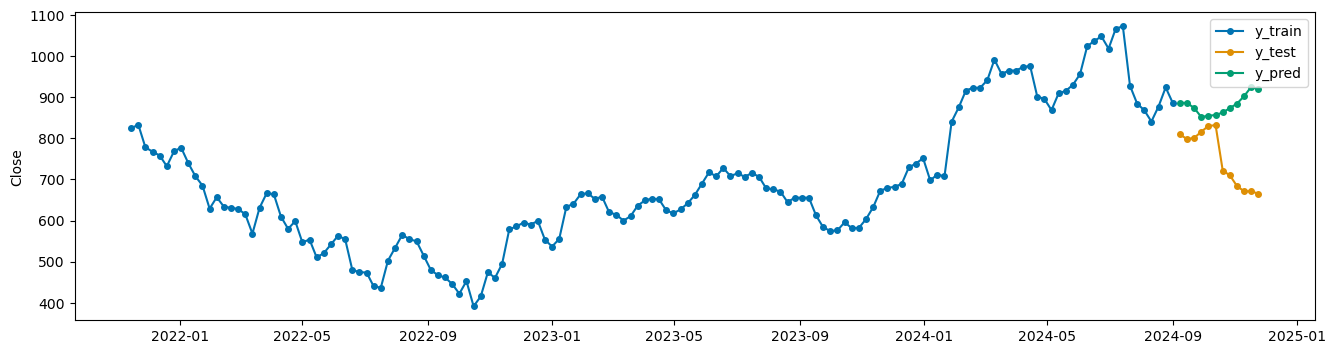

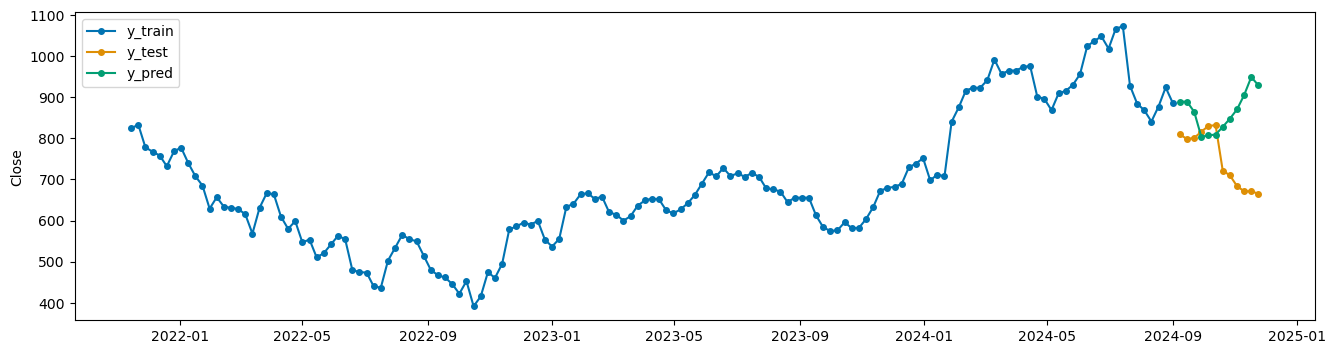

In [32]:
ets_model_add = ExponentialSmoothing(
    train_data, 
    trend='add',          # Can also use 'mul' for multiplicative trend
    seasonal='add',       # Can also use 'mul' for multiplicative seasonality
    seasonal_periods=52   # Adjust based on the seasonality of your data (e.g., 52 for weekly data)
)

# Fit the model to the training data
fitted_model_add = ets_model_add.fit()

# Generate predictions for the test set
y_pred_ets_add = fitted_model_add.forecast(len(test_data))

# Plot the training, test data, and predictions
plot_series(train_data[200:], test_data, y_pred_ets_add, labels=["y_train", "y_test", "y_pred"]);

print()

# Now we are going to calculate the metrics of the model. The RMSE and the MAPE
mape_ets_add = mean_absolute_percentage_error(test_data, y_pred_ets_add) * 100
print("MAPE_ETS_ADD: ", mape_ets_add)

rmse_ets_add = root_mean_squared_error(test_data, y_pred_ets_add)
print("RMSE_ETS_ADD: ", rmse_ets_add)

print()

# We are going to retry the ETS model but now we are going to modify the trend and seasonality to be multiplicative
ets_model_mul = ExponentialSmoothing(
    train_data, 
    trend='mul',          # Can also use 'add' for additive trend
    seasonal='mul',       # Can also use 'add' for additive seasonality
    seasonal_periods=52   # Adjust based on the seasonality of your data (e.g., 52 for weekly data)
)

# Fit the model to the training data
fitted_model_mul = ets_model_mul.fit()

# Generate predictions for the test set
y_pred_ets_mul = fitted_model_mul.forecast(len(test_data))

# Plot the training, test data, and predictions
plot_series(train_data[200:], test_data, y_pred_ets_mul, labels=["y_train", "y_test", "y_pred"]);

print()

# Now we are going to calculate the metrics of the model. The RMSE and the MAPE
mape_ets_mul = mean_absolute_percentage_error(test_data, y_pred_ets_mul) * 100
print("MAPE_ETS_MUL: ", mape_ets_mul)

rmse_ets_mul = root_mean_squared_error(test_data, y_pred_ets_mul)
print("RMSE_ETS_MUL: ", rmse_ets_mul)

**SARIMAX**

ADF Statistic: -0.8383404413156369
p-value: 0.8075996834601717
The series is not stationary. Applying differencing.
ADF Statistic after differencing: -17.001477682920466
p-value after differencing: 8.722312678897885e-30
The series is now stationary with differencing.



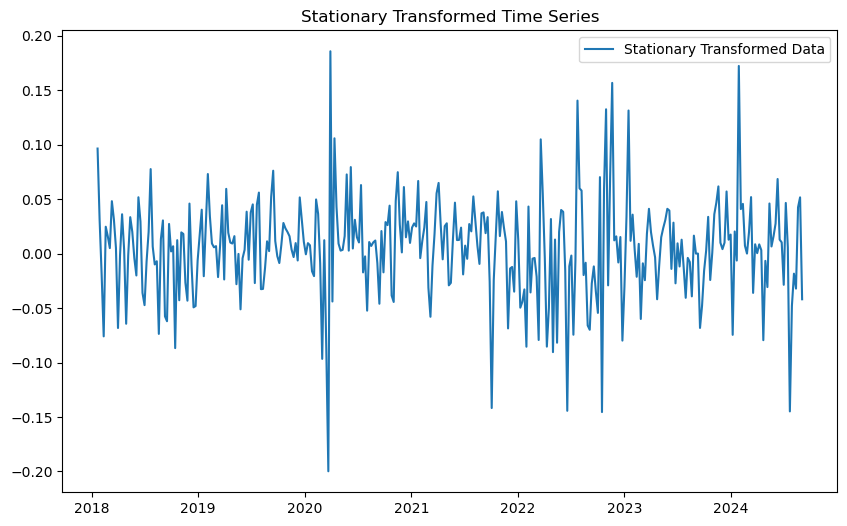



MAPE_SARIMAX:  16.69454194825537
RMSE_SARIMAX:  146.52589260916227


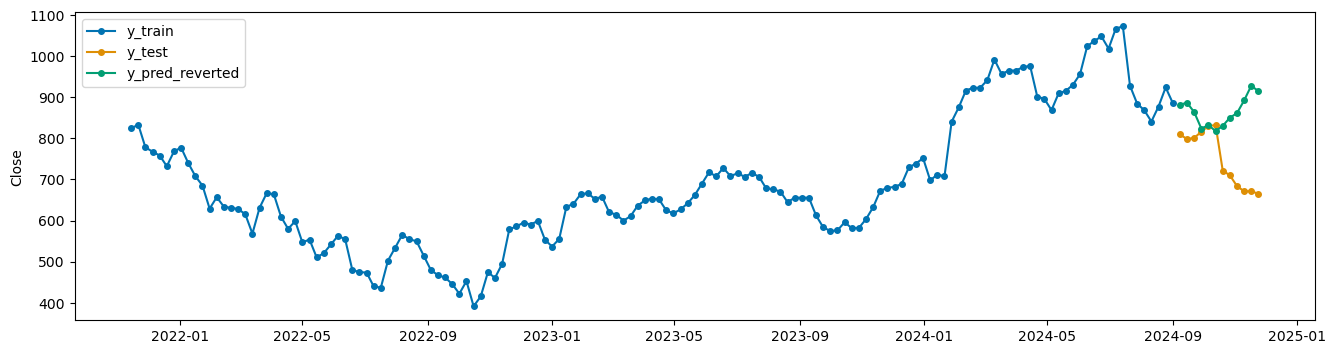

In [33]:
# Step 1: Log transformation (to stabilize variance)
log_train_data = np.log(train_data)

# Step 2: Check stationarity using the Augmented Dickey-Fuller test and Differencing if necessary
# Augmented Dickey-Fuller test
result = adfuller(log_train_data, autolag='AIC')
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')

if p_value > 0.05:
    print("The series is not stationary. Applying differencing.")
    # Differencing to achieve stationarity
    diff_log_train_data = log_train_data.diff().dropna()

    # Check stationarity again after differencing
    result_diff = adfuller(diff_log_train_data, autolag='AIC')
    p_value_diff = result_diff[1]
    print(f'ADF Statistic after differencing: {result_diff[0]}')
    print(f'p-value after differencing: {p_value_diff}')

    if p_value_diff > 0.05:
        print("The series is still not stationary.")
    else:
        print("The series is now stationary with differencing.")
    train_data_stationary = diff_log_train_data
else:
    print("The series is stationary with only log.")
    train_data_stationary = log_train_data
    
print()

# Plot the transformed data to visualize
plt.figure(figsize=(10, 6))
plt.plot(train_data_stationary, label='Stationary Transformed Data')
plt.title('Stationary Transformed Time Series')
plt.legend()
plt.show()

print()

# Initialize the SARIMA Model
sarima_model = SARIMAX(
    train_data_stationary,     # Training data that is stationary
    order=(1, 1, 1),           # ARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 52),  # Seasonal order (P, D, Q, s), here s=52 for weekly data
    enforce_stationarity=False,  # Allow the model to be non-stationary
    enforce_invertibility=False  # Allow the model to be non-invertible
)

# Fit the model to the training data
fitted_sarima = sarima_model.fit(disp=False)

# Generate predictions for the test set
y_pred_sarima = fitted_sarima.forecast(steps=len(test_data))

# Now we have to revert the transformations
# Step 1: Revert the differencing
# 'last_original_value' is the last value before differencing was applied
last_original_value = log_train_data.iloc[-1]

# Add back the last original value to get the cumulative sum and revert differencing
y_pred_sarima_diff_reverted = np.r_[last_original_value, y_pred_sarima].cumsum()

# Remove the first value to match the length of test_data
y_pred_sarima_diff_reverted = y_pred_sarima_diff_reverted[1:]

# Step 2: Revert the logarithmic transformation
y_pred_sarima_reverted = np.exp(y_pred_sarima_diff_reverted)

# Convert the reverted predictions to a pandas Series
y_pred_sarima_reverted = pd.Series(y_pred_sarima_reverted, index=test_data.index)

# Let's plot the data and predictions
# Plot the training, test data, and predictions
plot_series(train_data[200:], test_data, y_pred_sarima_reverted, labels=["y_train", "y_test", "y_pred_reverted"]);

print()

# Calculate MAPE for SARIMA model
mape_sarima = mean_absolute_percentage_error(test_data, y_pred_sarima_reverted) * 100
print("MAPE_SARIMAX: ", mape_sarima)

# Calculate RMSE for SARIMA model
rmse_sarima = root_mean_squared_error(test_data, y_pred_sarima_reverted)
print("RMSE_SARIMAX: ", rmse_sarima)

**Prophet**


MAPE_PROPHET:  29.752140833594343
RMSE_PROPHET:  231.35888291017747


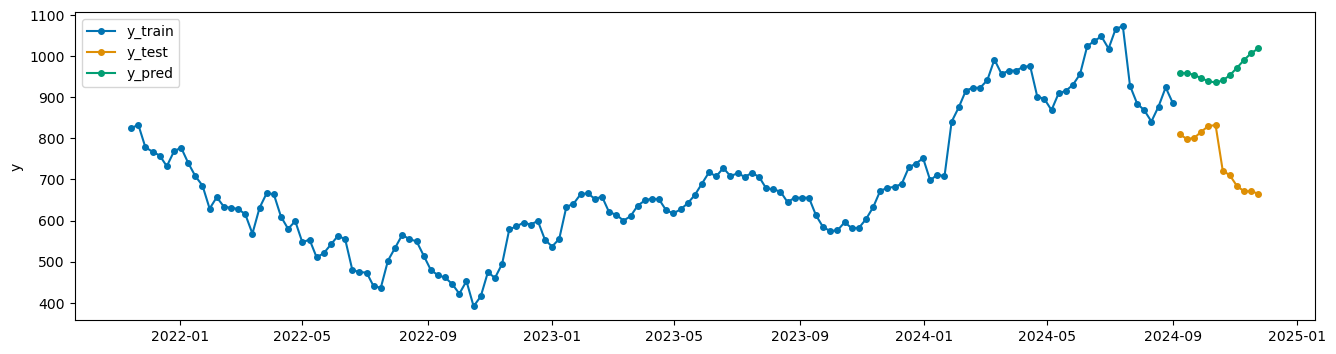

In [34]:
# Initialize the Prophet model
prophet_model = Prophet()

# Fit the model to the data
# First we need to modify the column names as is required by prophet
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})

prophet_model.fit(train_data_prophet)

# Define the forecast horizon (e.g., 16 periods into the future)
future = prophet_model.make_future_dataframe(periods=test_weeks, freq='W')

# Generate predictions
forecast = prophet_model.predict(future)

# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

# Plot the forecast results
plot_series(train_data_prophet[200:], test_data, forecast, labels=["y_train", "y_test", "y_pred"]);

print()

# Now we are going to calculate the metrics of the model. The RMSE and the MAPE
mape_prophet = mean_absolute_percentage_error(test_data, forecast) * 100
print("MAPE_PROPHET: ", mape_prophet)
rmse_prophet = root_mean_squared_error(test_data, forecast)
print("RMSE_PROPHET: ", rmse_prophet)

**XGboost**

RMSE_XGB:  149.88814607677392
MAPE_XGB:  18.596747180001024



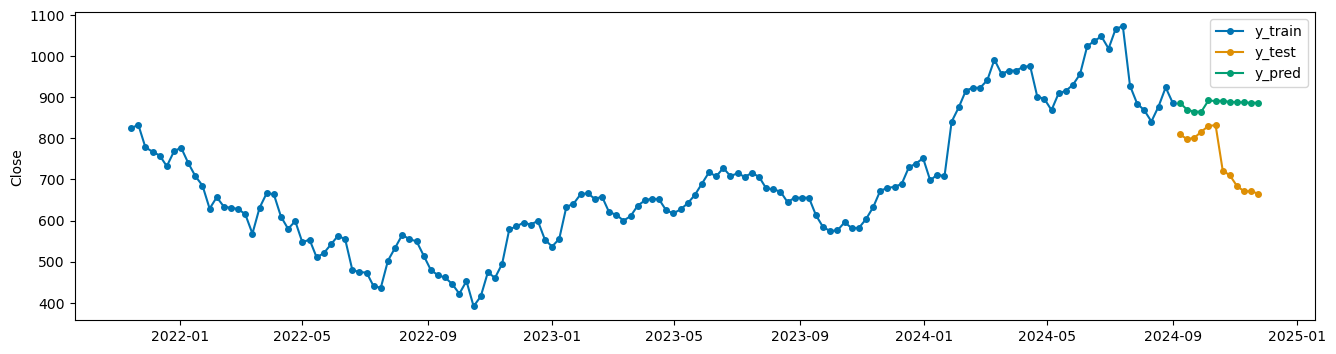

In [35]:
train_data_xgb_rf = create_features(train_data)
test_data_xgb_rf = create_features(test_data)

# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_xgb = train_data_xgb_rf.drop('Close', axis=1)
y_train_xgb = train_data_xgb_rf['Close']
X_test_xgb = test_data_xgb_rf.drop('Close', axis=1)
y_test_xgb = test_data_xgb_rf['Close']

# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

# Train the model
xgb_model.fit(X_train_xgb, y_train_xgb)

# Generate predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb = pd.DataFrame(y_pred_xgb, index=test_data.index, columns=['Close'])

# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb)
print("RMSE_XGB: ", rmse_xgb)

mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)*100
print("MAPE_XGB: ", mape_xgb)

print()

# Plot actual vs. predicted values
plot_series(y_train_xgb[200:], y_test_xgb, y_pred_xgb, labels=["y_train", "y_test", "y_pred"]);

**Random Forest**

RMSE_RANDOM FOREST:  161.9053194201459
MAPE_RANDOM FOREST:  20.625075704338723


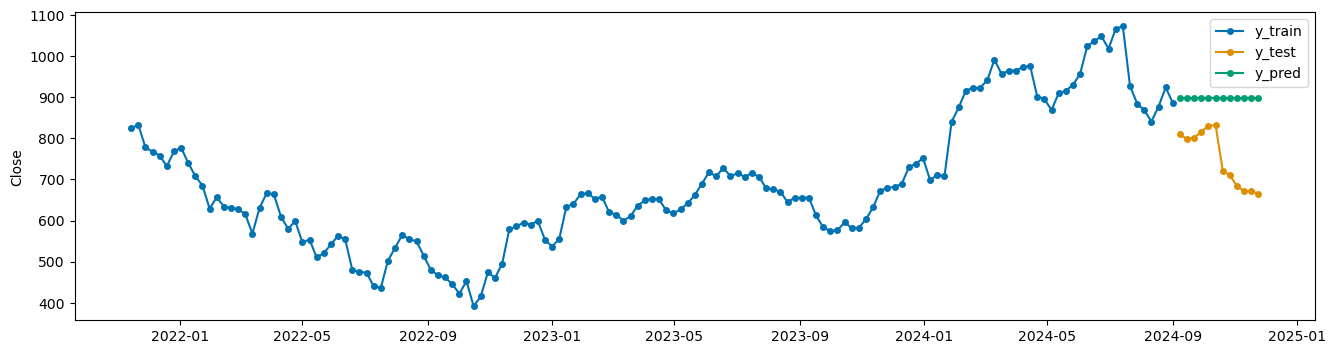

In [36]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_rf = train_data_xgb_rf.drop('Close', axis=1)
y_train_rf = train_data_xgb_rf['Close']
X_test_rf = test_data_xgb_rf.drop('Close', axis=1)
y_test_rf = test_data_xgb_rf['Close']

# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

# Train the model
rf_model.fit(X_train_rf, y_train_rf)

# Generate predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Convert predictions to a DataFrame with the same index as the test data
y_pred_rf = pd.DataFrame(y_pred_rf, index=test_data.index, columns=['Close'])

# Evaluate the model's performance
rmse_rf = root_mean_squared_error(y_test_rf, y_pred_rf)
print("RMSE_RANDOM FOREST: ", rmse_rf)

mape_rf = mean_absolute_percentage_error(y_test_rf, y_pred_rf)*100
print("MAPE_RANDOM FOREST: ", mape_rf)

# Plot actual vs. predicted values
plot_series(y_train_rf[200:], y_test_rf, y_pred_rf, labels=["y_train", "y_test", "y_pred"]);

**RMSE and MAPE comparison**

In [37]:
# Create a dictionary to store RMSE and MAPE for each model
metrics = {
    "Model": ["Naive", "ETS (Additive)", "ETS (Multiplicative)", "SARIMA", "Prophet", "XGBoost", "Random Forest"],
    "RMSE": [
        rmse_naive,
        rmse_ets_add,
        rmse_ets_mul,
        rmse_sarima,
        rmse_prophet,
        rmse_xgb,
        rmse_rf
    ],
    "MAPE": [
        mape_naive,
        mape_ets_add,
        mape_ets_mul,
        mape_sarima,
        mape_prophet,
        mape_xgb,
        mape_rf
    ]
}

In [38]:
# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_df

,Model,RMSE,MAPE
0,Naive,165.513064,17.949684
1,ETS (Additive),155.875636,18.548497
2,ETS (Multiplicative),154.609170,17.805998
3,SARIMA,146.525893,16.694542
4,Prophet,231.358883,29.752141
5,XGBoost,149.888146,18.596747
6,Random Forest,161.905319,20.625076


Our best model is Prophet as it has the lowest RMSE and MAPE

### 3.4.3 Fine-tunning

Let's investigate the following models after doing a fine-tunning: SARIMAX, Prophet, and XGBoost

**Sarimax**

We have commented the code below as the code takes 7 hrs to run

In [39]:
# # Define the range of values for the parameters (p, d, q) and seasonal parameters (P, D, Q, s)
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

# # Define variables to store the best model and its MAPE and RMSE
# best_mape = np.inf
# best_rmse = np.inf
# best_pdq = None
# best_seasonal_pdq = None
# best_model = None

# # Grid search
# total_combinations = len(pdq) * len(seasonal_pdq)  # Calculate total combinations
# current_combination = 0  # Counter for current combinations

# for param in pdq:
#     for seasonal_param in seasonal_pdq:
#         current_combination += 1
#         print(f"Testing combination {current_combination}/{total_combinations} -> order={param}, seasonal_order={seasonal_param}")

#         try:
#             # Fit the SARIMA model with current parameters
#             model = SARIMAX(train_data_stationary, 
#                             order=param, 
#                             seasonal_order=seasonal_param,
#                             enforce_stationarity=False, 
#                             enforce_invertibility=False)
#             results = model.fit(disp=False)
            
#             # Calculate the model's predictions
#             predictions = results.predict(start=0, end=len(train_data_stationary)-1)
            
#             # Calculate MAPE and RMSE
#             mape = np.mean(np.abs((train_data_stationary - predictions) / train_data_stationary)) * 100
#             rmse = np.sqrt(np.mean((train_data_stationary - predictions) ** 2))
            
#             # Update best model if its MAPE and RMSE are lower than the best found so far
#             if mape < best_mape and rmse < best_rmse:
#                 best_mape = mape
#                 best_rmse = rmse
#                 best_pdq = param
#                 best_seasonal_pdq = seasonal_param
#                 best_model = results

#         except Exception as e:
#             print(f"Error in combination {current_combination}: {e}")
#             continue

# print(f'\nBest SARIMA model: order={best_pdq}, seasonal_order={best_seasonal_pdq} with MAPE={best_mape} and RMSE={best_rmse}')


Looking at the results the SARIMA optimization doesn't converge therefore we won't take it into account.



**Prophet**

Best parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.0} with MAPE: 0.11267060875094555
MAPE_PROPHET_BEST:  11.267060875094554
RMSE_PROPHET_BEST:  102.39257244303934


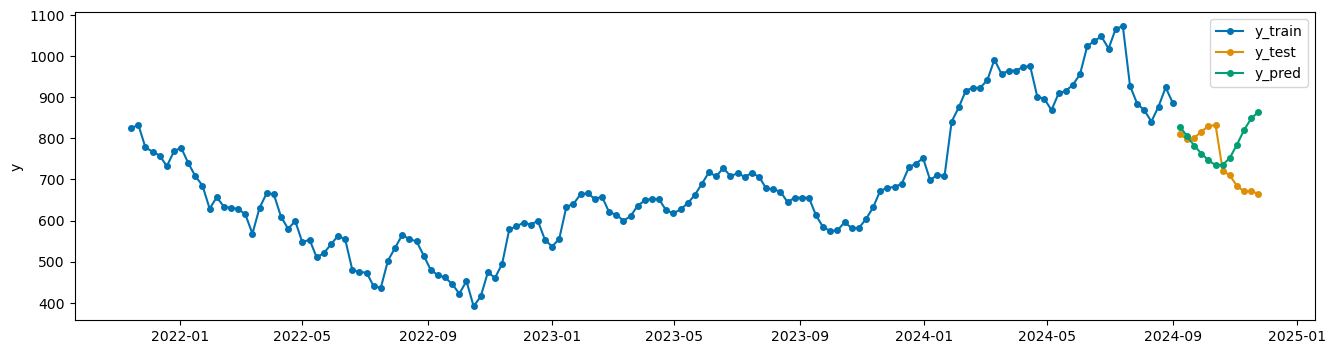

In [40]:
# Define the range of parameters
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.005, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 11.0, 12.0],
}

# Create combinations of parameters
grid = ParameterGrid(param_grid)

best_mape = float('inf')
best_params = None
best_model = None

for params in grid:
    model = Prophet(
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
    )
    
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})
    
    model.fit(train_data_prophet)

    # Generate predictions
    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test_data['Close'], forecast_filtered.loc[test_data.index])
    
    if mape < best_mape:
        best_mape = mape
        best_params = params
        best_model = model

print(f"Best parameters: {best_params} with MAPE: {best_mape}")

# Let's now do again the prophet model with the best parameters
# Initialize the Prophet model

prophet_model_best = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
)

# Fit the model to the data
# First we need to modify the column names as is required by prophet
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})

prophet_model_best.fit(train_data_prophet)

# Define the forecast horizon (e.g., 8 periods into the future)
future_best = prophet_model_best.make_future_dataframe(periods=test_weeks, freq='W')

# Generate predictions
forecast_best = prophet_model_best.predict(future_best)

# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_best = forecast_best[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

# Plot the forecast results
plot_series(train_data_prophet[200:], test_data, forecast_best, labels=["y_train", "y_test", "y_pred"]);

# Now we are going to calculate the metrics of the model. The RMSE and the MAPE
mape_prophet_best = mean_absolute_percentage_error(test_data, forecast_best) * 100
print("MAPE_PROPHET_BEST: ", mape_prophet_best)
rmse_prophet_best = root_mean_squared_error(test_data, forecast_best)
print("RMSE_PROPHET_BEST: ", rmse_prophet_best)

**XGBoost**

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'random_state': 42}
RMSE_XGB:  135.9158560728251
MAPE_XGB:  15.843403920572074



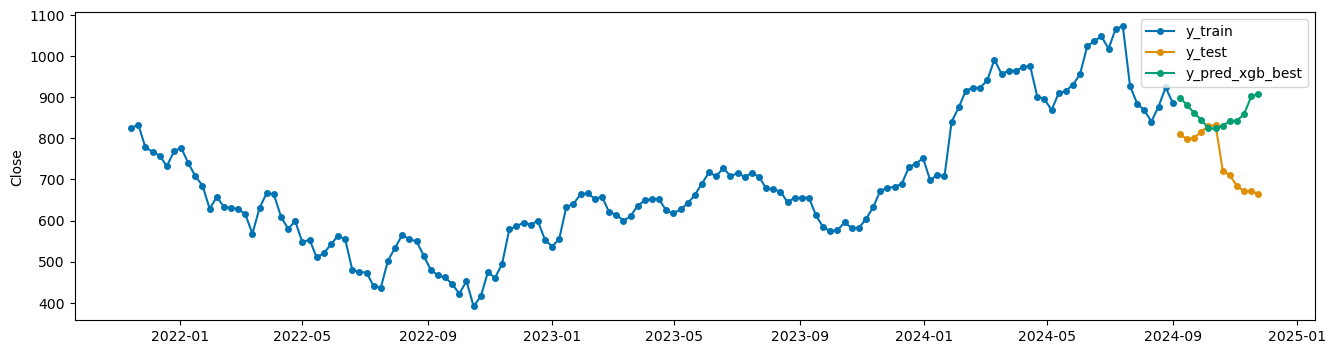

In [41]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 150],       # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinkage
    'max_depth': [3, 5, 7],               # Maximum depth of trees
    'random_state': [42]                  # For reproducibility
}

# Initialize the XGBoost model
xgb_model = XGBRegressor()

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',  # Use MAE as the scoring metric
    cv=3,                               # 5-fold cross-validation
    n_jobs=-1,                          # Use all available cores
    verbose=1                           # Show the training process
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_xgb, y_train_xgb)

# Get the best parameters found
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_xgb_best = best_xgb_model.predict(X_test_xgb)

# Convert predictions to a DataFrame with the same index as test_data
y_pred_xgb_best = pd.DataFrame(y_pred_xgb_best, index=test_data.index, columns=['Close'])

# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb_best)
print("RMSE_XGB: ", rmse_xgb)

mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb_best)*100
print("MAPE_XGB: ", mape_xgb)

print()

# Plot actual vs. predicted values
plot_series(y_train_xgb[200:], y_test_xgb, y_pred_xgb_best, labels=["y_train", "y_test", "y_pred_xgb_best"]);

### 3.4.4 Results

The final chosen model is the prophet as the MAPE and RMSE both improved

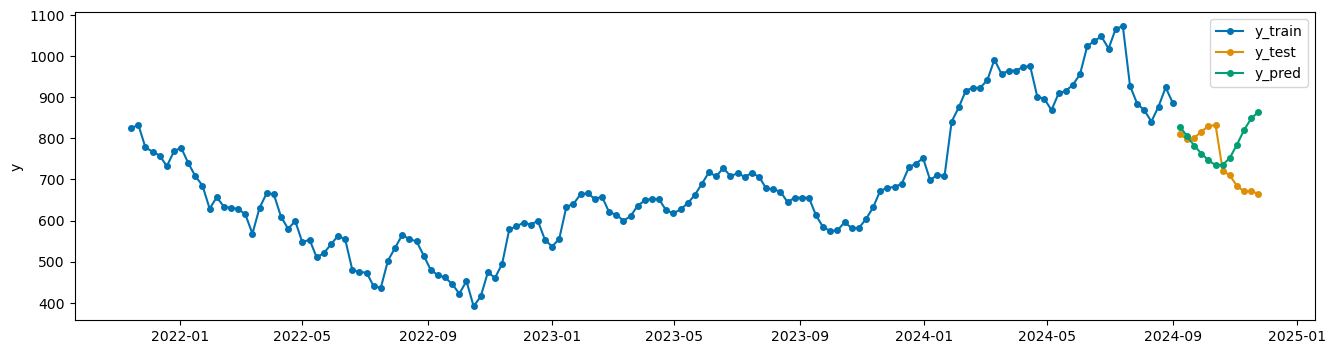

In [42]:
plot_series(train_data_prophet[200:], test_data, forecast_best, labels=["y_train", "y_test", "y_pred"]);

## 3.5 Selecting ASML suppliers

For a complete exploratory analysis of the ASML's suppliers stock time series, please refer to notebook [Go to Notebook 03_selecting_asml_suppliers.ipynb](02_selecting_asml_suppliers.ipynb)

We are going to load the data using the function get_historical_data

In [43]:
# Create an empty DataFrame for the merged data
merged_data = pd.DataFrame()

# Load historical data for each company and merge
for ticker, company_name in company_tickers.items():
    print(f"Loading data for {company_name}...")

    # Call the function get_historical_data for each ticker
    historical_data = get_historical_data(ticker, start_date, end_date)

    # Convert 'Date' column to datetime format and keep only the date (without time)
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

    # Rename 'Close' column to include the company name
    historical_data.rename(columns={'Close': f'Close_{company_name.replace(' ','_')}'}, inplace=True)

    # If merged_data is empty, initialize it with the first company's data
    if merged_data.empty:
        merged_data = historical_data[['Date', f'Close_{company_name.replace(' ','_')}']]
    else:
        # Merge with the existing DataFrame on 'Date'
        merged_data = merged_data.merge(historical_data[['Date', f'Close_{company_name.replace(' ','_')}']], on='Date', how='outer')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Display the merged data
merged_data.head()

Loading data for Carl_Zeiss_Meditec...
Loading data for Lam_Research_Corporation...
Loading data for Tokyo_Electron_Limited...


,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited
Date,,,
2018-01-02,59.144318,10.355885,30.773333
2018-01-03,59.808327,10.532056,31.266666
2018-01-04,59.808327,10.580202,32.273335
2018-01-05,59.808327,10.745433,32.513332
2018-01-08,61.117374,10.826403,32.746666


Now let's plot the stock data

****CARL_ZEISS_MEDITEC****



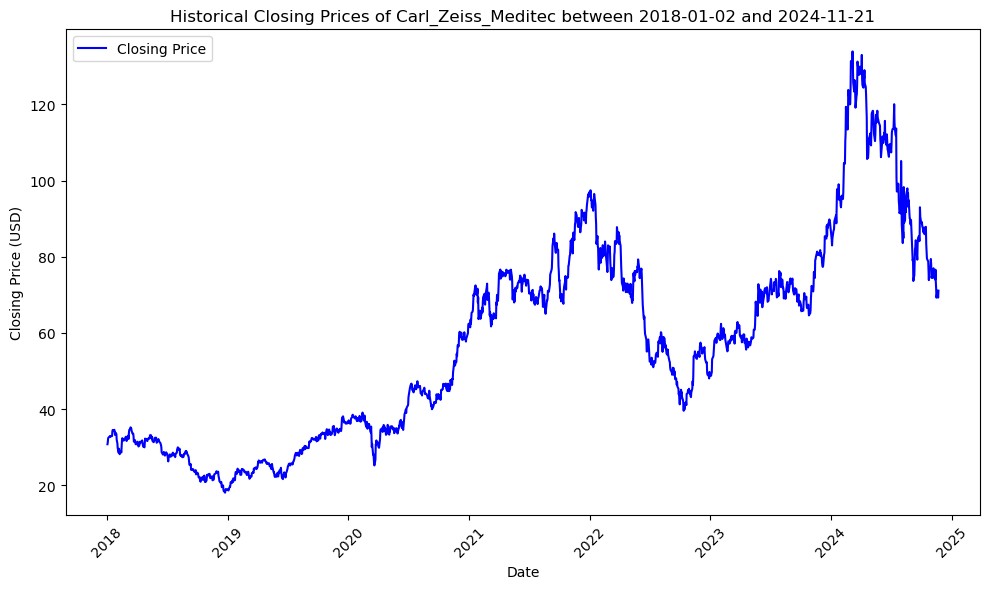


****LAM_RESEARCH_CORPORATION****



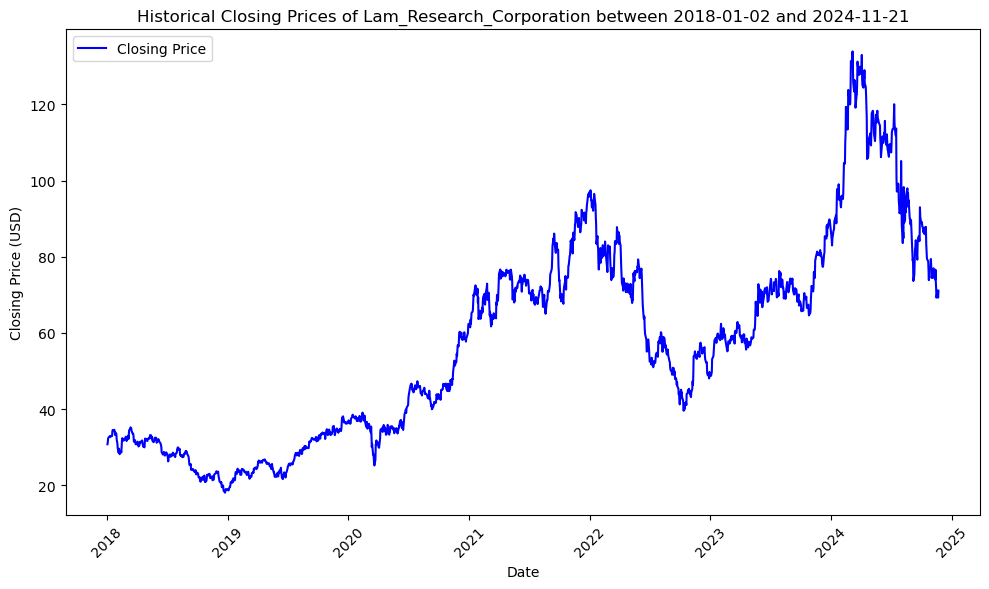


****TOKYO_ELECTRON_LIMITED****



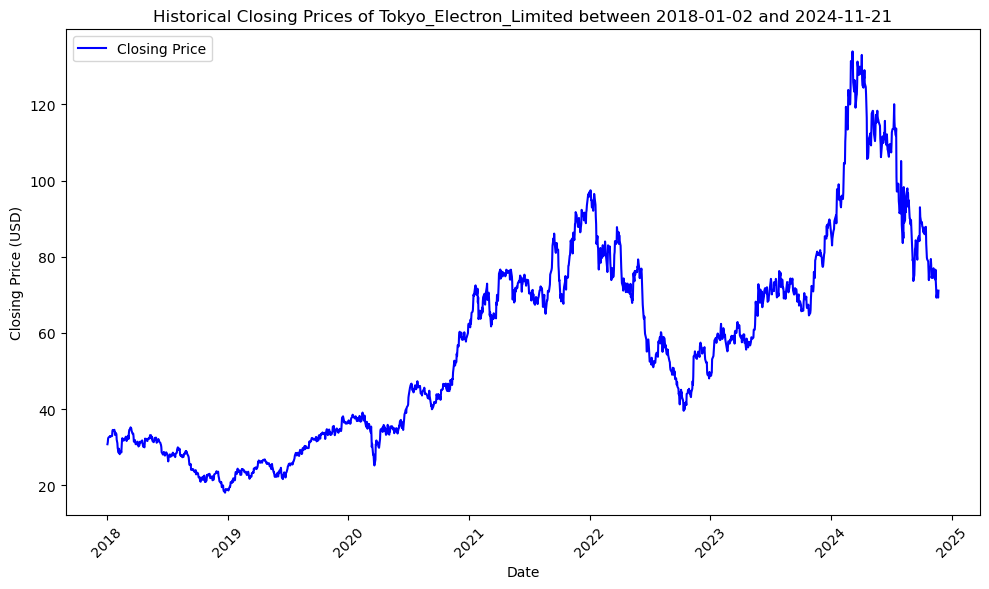

In [44]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_closing_prices(merged_data,f'Close_{company_name.replace(' ','_')}',company)
    print()

### 3.5.1 Checking for duplicate values

In [45]:
merged_data.duplicated().sum()

0

There are no duplicates as can be seen above

### 3.5.2 Checking for missing dates

In [46]:
(merged_data.isna().sum()/len(merged_data))*100

Close_Carl_Zeiss_Meditec          0.0
Close_Lam_Research_Corporation    0.0
Close_Tokyo_Electron_Limited      0.0
dtype: float64

As we can see there are no null values

### 3.5.3 Choosing the time series of our dataset

Let's chose just the weekly data for the suppliers. To be consistent with the logic with which we viewed ASML's stock data

In [47]:
# Ensure the index is a datetime index
if not isinstance(merged_data.index, pd.DatetimeIndex):  # Check if the index is already a DatetimeIndex
    merged_data.index = pd.to_datetime(merged_data.index)  # Convert the index to DatetimeIndex

# Remove unnecessary columns before resampling
columns_to_drop = ['Weekday', 'Month', 'Quarter']  # Drop non-relevant columns for resampling
merged_data = merged_data.drop(columns=columns_to_drop, errors='ignore')

# Resample the data to weekly frequency and calculate the median
weekly_data_suppliers = merged_data.resample('W').median()

# Display the weekly data
weekly_data_suppliers.head()

,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited
Date,,,
2018-01-07,59.808327,10.556129,31.770000
2018-01-14,60.946629,10.486096,32.766666
2018-01-21,60.851772,11.230453,34.386667
2018-01-28,61.373489,11.445199,34.026669
2018-02-04,61.335556,10.454366,31.420000


### 3.5.4 Prophet model for each supplier

#### 3.5.4.1 Train-test split

In [48]:
# Create dictionaries to store train and test dataframes for each company
train_dataframes = {}
test_dataframes = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Filter only the columns corresponding to the current company
    company_data = weekly_data_suppliers[[f'Close_{company}']]
    
    # Rename the column to 'Close'
    company_data.columns = ['Close']
    
    # Create train and test dataframes
    train_dataframes[company] = company_data[:-test_weeks]
    test_dataframes[company] = company_data[-test_weeks:]
    
    # Set 'Date' as the index of the dataframe
    train_dataframes[company].index.name = 'Date'
    test_dataframes[company].index.name = 'Date'

# Display the train dataframe for 'Carl Zeiss Meditec' as an example
train_dataframes['Carl_Zeiss_Meditec'].head()

,Close
Date,
2018-01-07,59.808327
2018-01-14,60.946629
2018-01-21,60.851772
2018-01-28,61.373489
2018-02-04,61.335556


#### 3.5.4.2 Prophet models

Forecasting for Carl_Zeiss_Meditec
MAPE: 12.12
RMSE: 9.06


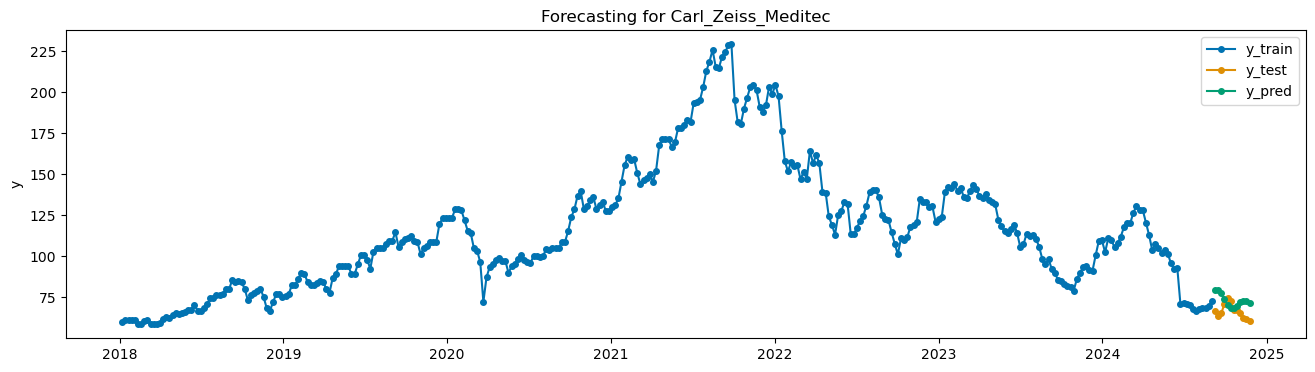

Forecasting for Lam_Research_Corporation
MAPE: 30.55
RMSE: 23.59


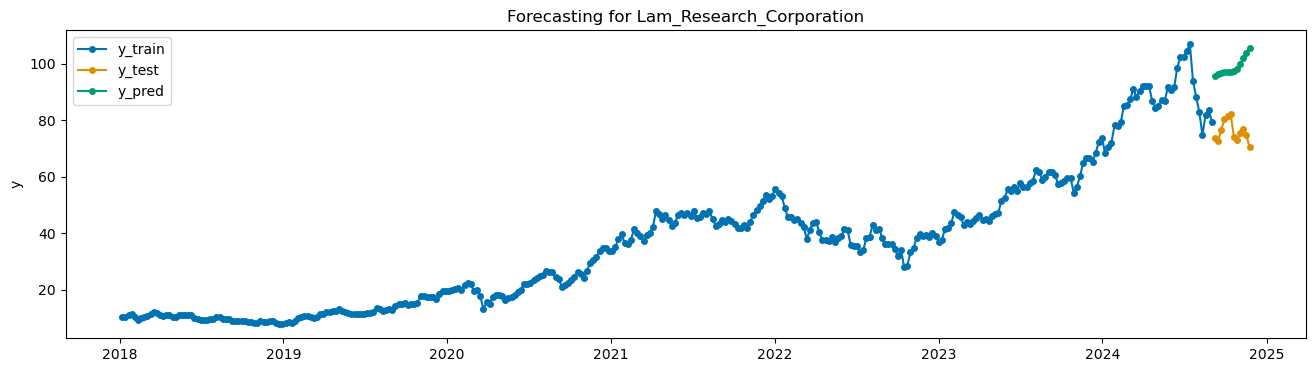

Forecasting for Tokyo_Electron_Limited
MAPE: 47.21
RMSE: 38.15


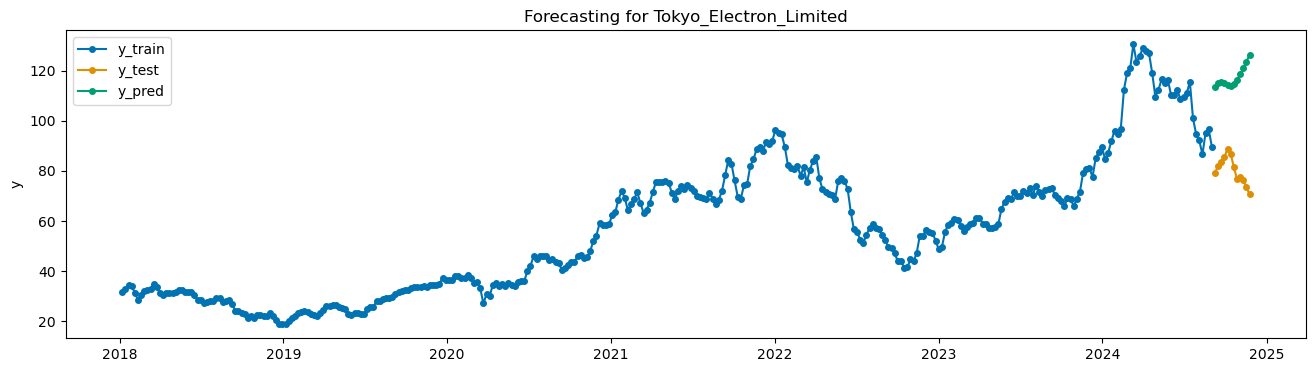

In [49]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    
    # Prepare the data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_data_prophet)

    # Define the forecast horizon (e.g., 12 periods into the future)
    future = prophet_model.make_future_dataframe(periods=test_weeks, freq='W')

    # Generate the predictions
    forecast = prophet_model.predict(future)

    # Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
    forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Ensure 'ds' is the index of train_data_prophet 
    train_data_prophet = train_data_prophet.set_index('ds')

    # Calculate MAPE and RMSE errors
    actuals = test_dataframes[company]['Close']  # Actual values from test data
    predictions = forecast['Close']              # Predicted values from forecast

    # Ensure the indices of actuals and predictions align
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]

    mape = mean_absolute_percentage_error(actuals, predictions)*100
    rmse = root_mean_squared_error(actuals, predictions)

    # Display errors
    print(f'Forecasting for {company}')
    print(f'MAPE: {mape:.2f}')
    print(f'RMSE: {rmse:.2f}')
    
    # Plot the forecast results
    plot_series(
        train_data_prophet[-500:],  # Only pass the 'Close' column for training data
        test_dataframes[company],   # Only pass the 'Close' column for test data
        forecast,                   # Only pass the 'Close' column for forecast
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Forecasting for {company}')  # Add title for better clarity
    plt.show()  # Show the plot before moving to the next company

#### 3.5.4.3 Fine-tunning the prophet models

Both cells for the Prophet fine-tuning code below take approximately 30 minutes each to run. Therefore, they have been commented out, and we will directly load the pickle files containing the best Prophet models for ASML's suppliers from the notebook 03_selecting_asml_suppliers.

If you would like to obtain the latest results, please run the notebook 03_selecting_asml_suppliers to update the pickle files with the best Prophet models for ASML's suppliers.

In [50]:
# # Dictionary to store the best parameters, MAPE, and RMSE for each company
# best_params_per_company = {}
# final_mape_per_company = {}
# final_rmse_per_company = {}
# company_params = {}

# # Define parameter grid
# param_grid = {
#     "changepoint_prior_scale": [round(x, 3) for x in np.arange(0.001, 1.001, 0.1)],
#     "seasonality_prior_scale": [round(x, 2) for x in np.arange(0.01, 10.1, 1)],
#     "seasonality_mode": ['multiplicative'],
#     "weekly_seasonality": [True, False],
#     "yearly_seasonality": [True, False],
#     "daily_seasonality": [True, False]
# }

# # Create a parameter grid generator
# grid = ParameterGrid(param_grid)

# # Loop through each company in company_tickers
# for ticker, company in company_tickers.items():
#     print(f"Optimizing for {company}...")

#     # Prepare training and test data for Prophet
#     train_data = train_dataframes[company][['Close']].copy()
#     train_data.index = pd.to_datetime(train_data.index)
#     train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

#     test_data = test_dataframes[company][['Close']].copy()
#     test_data.index = pd.to_datetime(test_data.index)

#     # Initialize variables to track the best parameters
#     best_mape = float('inf')
#     best_rmse = float('inf')
#     best_params = None
#     best_forecast = None

#     # Perform grid search using ParameterGrid
#     for params in grid:
#         try:
#             # Train the Prophet model
#             model = Prophet(
#                 changepoint_prior_scale=params["changepoint_prior_scale"],
#                 seasonality_prior_scale=params["seasonality_prior_scale"],
#                 seasonality_mode=params["seasonality_mode"],
#                 weekly_seasonality=params["weekly_seasonality"],
#                 yearly_seasonality=params["yearly_seasonality"],
#                 daily_seasonality=params["daily_seasonality"]
#             )
#             model.fit(train_data_prophet)

#             # Make predictions
#             future = model.make_future_dataframe(periods=test_weeks, freq='W')
#             forecast = model.predict(future)
#             forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

#             # Calculate MAPE
#             actuals = test_data['Close']
#             predictions = forecast_filtered['Close']
#             common_index = actuals.index.intersection(predictions.index)
#             mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100

#             # Calculate RMSE
#             actuals = actuals.loc[common_index]
#             predictions = predictions.loc[common_index]
#             rmse = root_mean_squared_error(actuals, predictions)

#             # Update the best parameters if the current MAPE is lower
#             if mape < best_mape:
#                 best_mape = mape
#                 best_rmse = rmse
#                 best_params = params
#                 best_forecast = forecast_filtered

#         except Exception as e:
#             print(f"\nError with parameters {params}: {e}")

#     # Save the best parameters and performance metrics
#     best_params_per_company[company] = best_params
#     final_mape_per_company[company] = best_mape
#     final_rmse_per_company[company] = best_rmse
#     company_params[company] = best_params

#     # Print the best parameters, MAPE, and RMSE for the company
#     print(f"\nForecasting for {company}:")
#     print(f"Best parameters: {best_params}")
#     print(f"MAPE: {best_mape:.2f}")
#     print(f"RMSE: {best_rmse:.2f}")

#     # Plot the forecast results for the company
#     plot_series(
#         train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
#         test_data['Close'],
#         best_forecast['Close'],
#         labels=["y_train", "y_test", "y_pred"]
#     )
#     plt.title(f"Forecasting for {company}")
#     plt.show()

Now let's run a specific param_grid for each of the companies.
(Expected execution time 10-15 minutes)

In [51]:
# # Dictionary to store each Prophet model by company
# prophet_models = {}

# # Iterate over each company in company_params
# for company, params in company_params.items():
#     print(f"\nProcessing company: {company}...\n")

#     # Define the parameter grid for the current company
#     param_grid = {
#         'changepoint_prior_scale': np.round(
#             np.linspace(params['changepoint_prior_scale'] / 2, params['changepoint_prior_scale'] * 2, 10), 5
#         ),
#         'seasonality_prior_scale': np.round(
#             np.linspace(params['seasonality_prior_scale'] / 2, params['seasonality_prior_scale'] * 2, 10), 5
#         ),
#         'seasonality_mode': ['multiplicative'],
#         'weekly_seasonality': [True, False],
#         'yearly_seasonality': [True, False],
#         'daily_seasonality': [True, False]
#     }

#     # Generate all parameter combinations using ParameterGrid
#     param_combinations = list(ParameterGrid(param_grid))

#     # Prepare training and test data for Prophet
#     train_data = train_dataframes[company][['Close']].copy()
#     train_data.index = pd.to_datetime(train_data.index)
#     train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

#     test_data = test_dataframes[company][['Close']].copy()
#     test_data.index = pd.to_datetime(test_data.index)

#     # Initialize variables to track the best parameters
#     best_mape = float('inf')
#     best_rmse = float('inf')
#     best_params = None

#     # Iterate over all parameter combinations
#     for combination in param_combinations:
#         try:
#             # Fit the Prophet model with the current parameter combination
#             model = Prophet(
#                 changepoint_prior_scale=combination['changepoint_prior_scale'],
#                 seasonality_prior_scale=combination['seasonality_prior_scale'],
#                 seasonality_mode=combination['seasonality_mode'],
#                 weekly_seasonality=combination['weekly_seasonality'],
#                 yearly_seasonality=combination['yearly_seasonality'],
#                 daily_seasonality=combination['daily_seasonality']
#             )
#             model.fit(train_data_prophet)

#             # Make predictions
#             future = model.make_future_dataframe(periods=test_weeks, freq='W')
#             forecast = model.predict(future)
#             forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

#             # Calculate MAPE and RMSE
#             actuals = test_data['Close']
#             predictions = forecast_filtered['Close']
#             common_index = actuals.index.intersection(predictions.index)
#             actuals = actuals.loc[common_index]
#             predictions = predictions.loc[common_index]

#             mape = mean_absolute_percentage_error(actuals, predictions) * 100
#             rmse = root_mean_squared_error(actuals, predictions)

#             # Update the best parameters if the current MAPE is lower
#             if mape < best_mape:
#                 best_mape = mape
#                 best_rmse = rmse
#                 best_params = combination
#         except Exception as e:
#             print(f"Error with parameters: {combination}: {e}")

#     # Print the best parameters, MAPE, and RMSE for the current company
#     print(f"\nBest parameters for {company}: {best_params}")
#     print(f"MAPE: {best_mape:.2f}")
#     print(f"RMSE: {best_rmse:.2f}")

#     # Plot the forecast results for the best parameters
#     model = Prophet(
#         changepoint_prior_scale=best_params['changepoint_prior_scale'],
#         seasonality_prior_scale=best_params['seasonality_prior_scale'],
#         seasonality_mode=best_params['seasonality_mode'],
#         weekly_seasonality=best_params['weekly_seasonality'],
#         yearly_seasonality=best_params['yearly_seasonality'],
#         daily_seasonality=best_params['daily_seasonality']
#     )
#     model.fit(train_data_prophet)

#     future = model.make_future_dataframe(periods=test_weeks, freq='W')
#     forecast = model.predict(future)
#     forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

#     plot_series(
#         train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
#         test_data['Close'],
#         forecast_filtered['Close'],
#         labels=["y_train", "y_test", "y_pred"]
#     )
#     plt.title(f"Forecasting for {company}")
#     plt.show()

#     # Fit the Prophet model with all data (train and test) for final storage
#     prophet_model = Prophet(
#         changepoint_prior_scale=best_params['changepoint_prior_scale'],
#         seasonality_prior_scale=best_params['seasonality_prior_scale'],
#         seasonality_mode=best_params['seasonality_mode'],
#         weekly_seasonality=best_params['weekly_seasonality'],
#         yearly_seasonality=best_params['yearly_seasonality'],
#         daily_seasonality=best_params['daily_seasonality']
#     )

#     # Prepare combined data for final model training
#     test_data = pd.DataFrame(actuals).rename(columns={'Close': 'y'}).reset_index(names="ds")
#     all_data = pd.concat([train_data_prophet, test_data])
#     prophet_model.fit(all_data)

#     # Store the model in the dictionary with the company name as key
#     prophet_models[company] = prophet_model

**Here is the end result after loading the pickles of ASML's suppliers**

In [52]:
# Create an empty dictionary to store the loaded models
models_suppliers_train = {}

# Iterate over each supplier in company_tickers to load its model
for company in company_tickers.values():
    # Define the file path to the model pickle file for the current supplier
    model_path = f'models/prophet_asml_supplier_train_{company.replace(" ", "_")}.pkl'

    # Load the model and store it in the dictionary using the supplier's name
    models_suppliers_train[company] = joblib.load(model_path)
    print(f'Prophet model for {company} loaded from {model_path}')

Prophet model for Carl_Zeiss_Meditec loaded from models/prophet_asml_supplier_train_Carl_Zeiss_Meditec.pkl
Prophet model for Lam_Research_Corporation loaded from models/prophet_asml_supplier_train_Lam_Research_Corporation.pkl
Prophet model for Tokyo_Electron_Limited loaded from models/prophet_asml_supplier_train_Tokyo_Electron_Limited.pkl


MAPE: 8.75
RMSE: 7.16


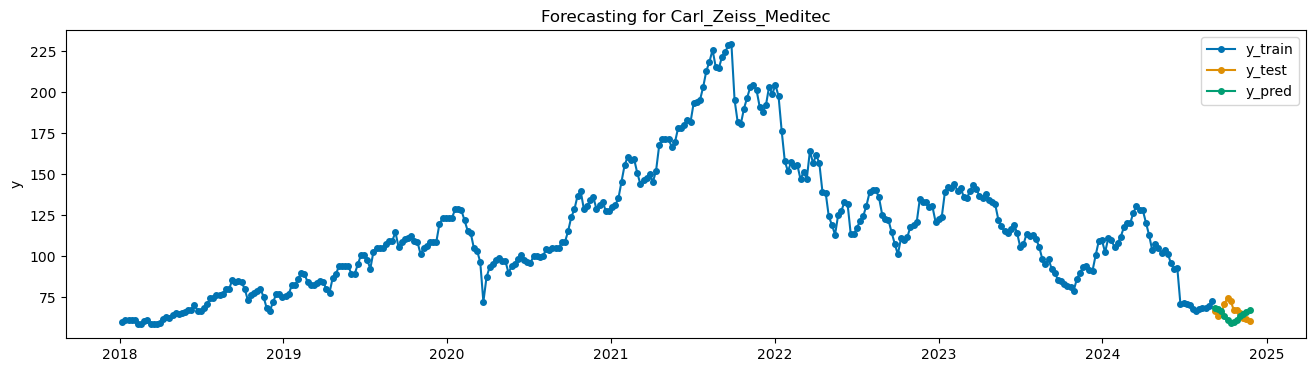

MAPE: 3.97
RMSE: 3.76


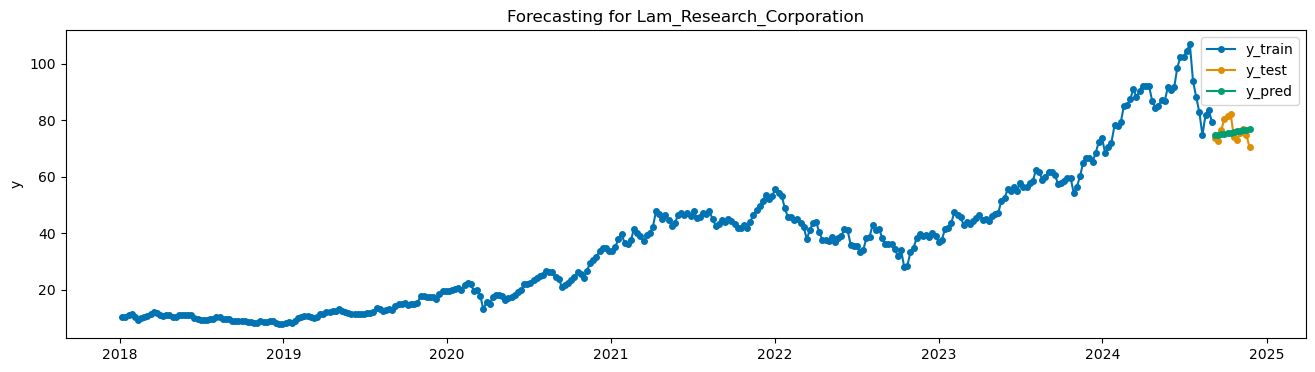

MAPE: 6.06
RMSE: 5.64


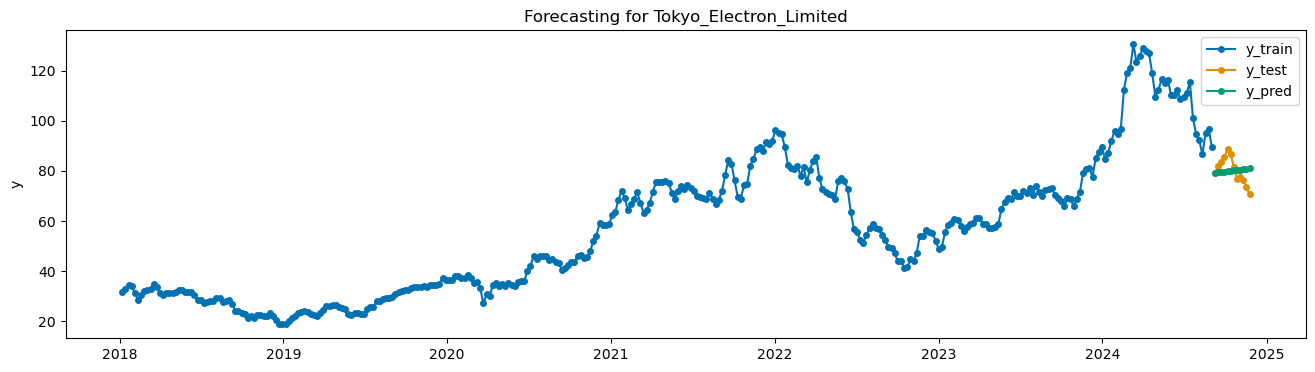

In [53]:
# Iterate over each supplier in company_tickers to make predictions
for company in company_tickers.values():
    
    # Prepare training and test data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    test_data = test_dataframes[company][['Close']].copy()
    test_data.index = pd.to_datetime(test_data.index)
        
    # Get the loaded Prophet model for the current supplier from the models_suppliers_train dictionary
    model = models_suppliers_train[company]

    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]    
    
    # Calculate MAPE and RMSE
    actuals = test_data['Close']
    predictions = forecast_filtered['Close']
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]
    
    mape = mean_absolute_percentage_error(actuals, predictions) * 100
    rmse = root_mean_squared_error(actuals, predictions)
    
    print(f"MAPE: {mape:.2f}")
    print(f"RMSE: {rmse:.2f}")


    plot_series(
        train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
        test_data['Close'],
        forecast_filtered['Close'],
        labels=["y_train", "y_test", "y_pred"]
    )
    plt.title(f"Forecasting for {company}")
    plt.show()

## 3.6 Data Preparation

For a complete exploratory analysis of the ASML stock time series, please refer to notebook [Go to Notebook 04_data_preparation.ipynb](04_data_preparation.ipynb)

### 3.6.1 Joining weekly_data_ asml and weekly_data_suppliers

Let's create a weekly_data dataframe from both weekly_data_asml and weekly_data_suppliers

In [54]:
weekly_data = weekly_data_asml.join(weekly_data_suppliers, how='inner')
weekly_data.head()

,Close,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited
Date,,,,
2018-01-14,168.662354,60.946629,10.486096,32.766666
2018-01-21,185.736526,60.851772,11.230453,34.386667
2018-01-28,191.564697,61.373489,11.445199,34.026669
2018-02-04,187.825363,61.335556,10.454366,31.420000
2018-02-11,174.080215,58.831284,9.320186,28.526667


Display the total number of nulls per column


In [55]:
nulls_per_column = weekly_data.isnull().sum()

nulls_per_column

Close                             0
Close_Carl_Zeiss_Meditec          0
Close_Lam_Research_Corporation    0
Close_Tokyo_Electron_Limited      0
dtype: int64

### 3.6.2 Add binary variables

In [56]:
# Apply the function to weekly_data
add_exogenous_variables(weekly_data)

In [57]:
weekly_data_combination = weekly_data.copy()
weekly_data_combination.head()

,Close,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2018-01-14,168.662354,60.946629,10.486096,32.766666,0,0,0,0,0,0
2018-01-21,185.736526,60.851772,11.230453,34.386667,0,0,0,0,0,0
2018-01-28,191.564697,61.373489,11.445199,34.026669,0,0,0,0,0,0
2018-02-04,187.825363,61.335556,10.454366,31.420000,0,0,0,0,0,0
2018-02-11,174.080215,58.831284,9.320186,28.526667,0,0,0,0,0,0


## 3.7 Modelling

For a complete exploratory analysis of the ASML stock time series, please refer to notebook [Go to Notebook 05_modelling.ipynb](05_modelling.ipynb)

### 3.7.1 Train test split

We are going to consider *test_weeks* as the number of weeks we want the test to have

In [58]:
train_data = weekly_data_combination[:-test_weeks]
train_data.head()

,Close,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2018-01-14,168.662354,60.946629,10.486096,32.766666,0,0,0,0,0,0
2018-01-21,185.736526,60.851772,11.230453,34.386667,0,0,0,0,0,0
2018-01-28,191.564697,61.373489,11.445199,34.026669,0,0,0,0,0,0
2018-02-04,187.825363,61.335556,10.454366,31.420000,0,0,0,0,0,0
2018-02-11,174.080215,58.831284,9.320186,28.526667,0,0,0,0,0,0


In [59]:
test_data = weekly_data_combination[-test_weeks:]
test_data.head()

,Close,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2024-09-08,809.584839,66.605000,73.712814,79.215000,0,1,1,1,1,1
2024-09-15,798.271362,63.835999,72.510414,82.000000,0,1,1,1,1,1
2024-09-22,801.164551,65.324997,76.603996,83.349998,0,1,1,1,1,1
2024-09-29,816.269165,70.800003,80.375000,85.470001,0,1,1,1,1,1
2024-10-06,830.465942,74.760002,81.408997,88.830002,0,1,1,1,1,1


### 3.7.2 Trying outmodels

**SARIMAX**

As we saw in notebook 02_forecasting, the series was not stationary, thus we will make the target variable stationary (which is 'Close_ASML') following the same logic that was done in notebook 02_forecasting

ADF Statistic: -0.8383404413156369
p-value: 0.8075996834601717
The series is not stationary. Applying differencing.
ADF Statistic after differencing: -17.001477682920466
p-value after differencing: 8.722312678897885e-30
The series is now stationary with differencing.


MAPE_SARIMAX:  13.741369697689668
RMSE_SARIMAX:  119.65435035653144


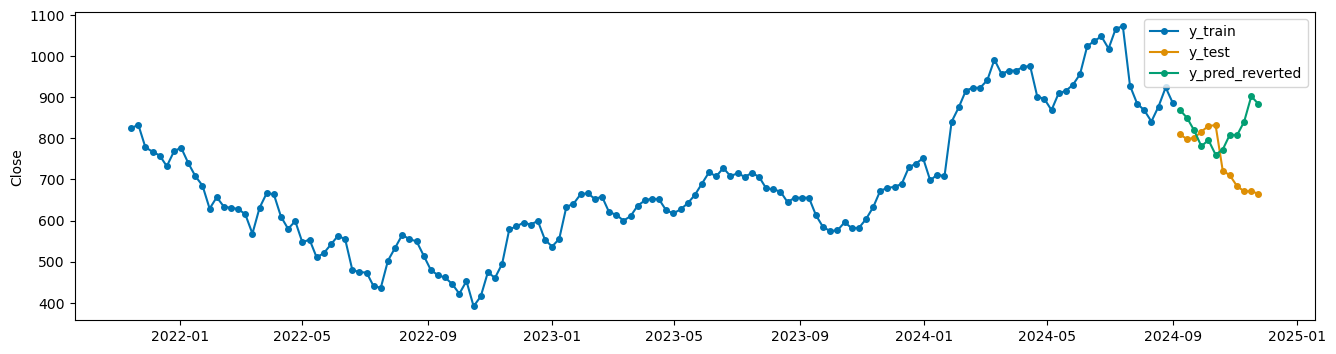

In [60]:
# Step 1: Log transformation (to stabilize variance)
log_train_data = np.log(train_data['Close'])

# Step 2: Check stationarity using the Augmented Dickey-Fuller test and Differencing if necessary
# Augmented Dickey-Fuller test
result = adfuller(log_train_data, autolag='AIC')
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')

if p_value > 0.05:
    print("The series is not stationary. Applying differencing.")
    # Differencing to achieve stationarity
    diff_log_train_data = log_train_data.diff().dropna()

    # Check stationarity again after differencing
    result_diff = adfuller(diff_log_train_data, autolag='AIC')
    p_value_diff = result_diff[1]
    print(f'ADF Statistic after differencing: {result_diff[0]}')
    print(f'p-value after differencing: {p_value_diff}')

    if p_value_diff > 0.05:
        print("The series is still not stationary.")
    else:
        print("The series is now stationary with differencing.")
    train_data_stationary = diff_log_train_data
else:
    print("The series is stationary with only log.")
    train_data_stationary = log_train_data

print()

# Once we have the stationary series, we initialize the SARIMAX model with the corresponding regressor variables
# Creating the exogenous variables
exog = train_data.drop(['Close'], axis=1)
# Deleting the first row of exog due to the differentiation
exog = exog[1:]

# Initializing the SARIMAX model
sarima_model = SARIMAX(
    train_data_stationary,     # Training data that is stationary
    exog=exog,                 # Exogenous variables
    order=(1, 1, 1),           # ARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 52),  # Seasonal order (P, D, Q, s), here s=52 for weekly data
    enforce_stationarity=False,  # Allow the model to be non-stationary
    enforce_invertibility=False  # Allow the model to be non-invertible
)

# Fit the model to the training data
fitted_sarima = sarima_model.fit(disp=False)

# Generate predictions the future_exog variable
future_exog = test_data.drop('Close', axis=1)

# Assuming `future_exog` contains the future values of the exogenous variables for the forecast period
y_pred_sarima = fitted_sarima.forecast(steps=len(test_data), exog=future_exog)

# Now we have to revert the transformations
# Step 1: Revert the differencing
# 'last_original_value' is the last value before differencing was applied
last_original_value = log_train_data.iloc[-1]

# Add back the last original value to get the cumulative sum and revert differencing
y_pred_sarima_diff_reverted = np.r_[last_original_value, y_pred_sarima].cumsum()

# Remove the first value to match the length of test_data
y_pred_sarima_diff_reverted = y_pred_sarima_diff_reverted[1:]

# Step 2: Revert the logarithmic transformation
y_pred_sarima_reverted = np.exp(y_pred_sarima_diff_reverted)

# Convert the reverted predictions to a pandas Series
y_pred_sarima_reverted = pd.Series(y_pred_sarima_reverted, index=test_data.index)

# Let's plot the data and predictions
# Plot the training, test data, and predictions
plot_series(train_data['Close'][200:], test_data['Close'], y_pred_sarima_reverted, labels=["y_train", "y_test", "y_pred_reverted"]);

print()

# Calculate MAPE for SARIMA model
mape_sarima = mean_absolute_percentage_error(test_data['Close'], y_pred_sarima_reverted) * 100
print("MAPE_SARIMAX: ", mape_sarima)

# Calculate RMSE for SARIMA model
rmse_sarima = root_mean_squared_error(test_data['Close'], y_pred_sarima_reverted)
print("RMSE_SARIMAX: ", rmse_sarima)

The results are not good if they're compared with those of notebook 02_forecasting. So, we are disregarding the SARIMAX model for now.

**Prophet**

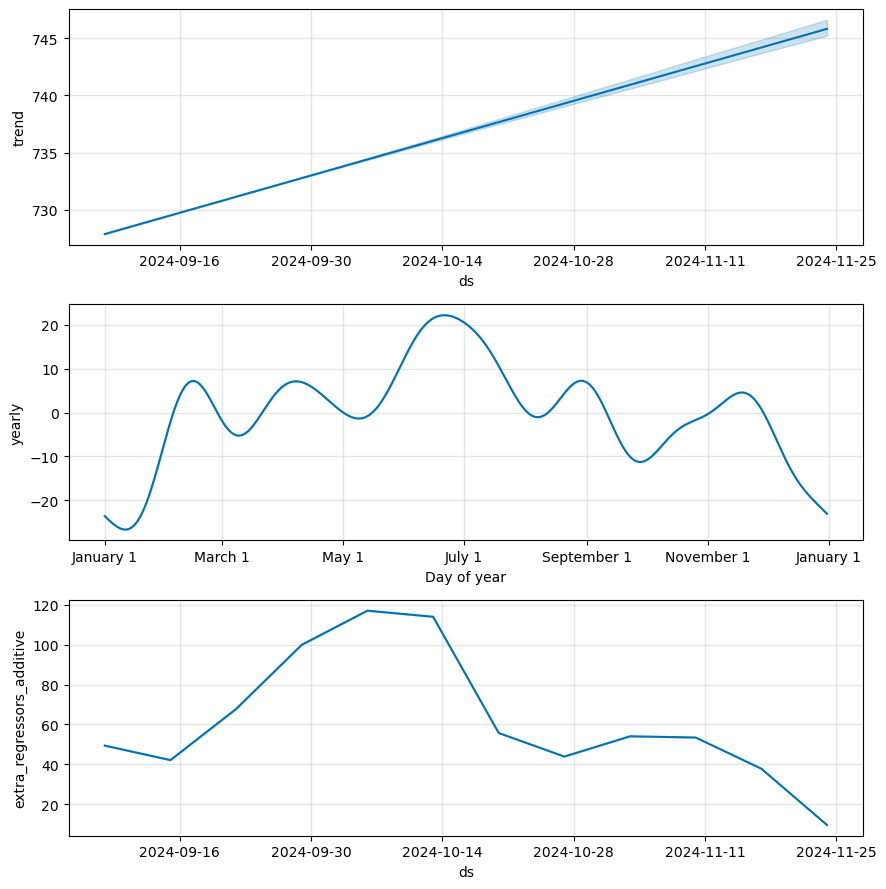

In [61]:
# Initialize the Prophet model
prophet_model = Prophet()

# Fit the model to the data
# First we need to modify the column names as is required by prophet
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})
test_data_prophet = test_data.reset_index(names="ds").rename(columns={'Close':'y'})

# Add each regressor to the Prophet model
# Define the regressors list
regressors = list(test_data_prophet.columns)

# Exclude 'y' and 'ds' from the regressors list
regressors = [col for col in regressors if col not in ['y', 'ds']]

for regressor in regressors:
    prophet_model.add_regressor(regressor)
    
# Fit the model
prophet_model.fit(train_data_prophet)

# Generate predictions
forecast = prophet_model.predict(test_data_prophet[[column for column in test_data_prophet if column != 'y']])

# Plot forecast components (trend, weekly, yearly components)
fig2 = prophet_model.plot_components(forecast)
plt.show()

The Prophet model's forecast shows a steady upward trend, indicating growth over time. There is clear yearly seasonality, with peaks around July and dips towards the year's end, suggesting cyclical behavior. An additional regressor also impacts the forecast, introducing periodic fluctuations that align with external factors. Together, these components suggest the forecast is influenced by an overall upward trend, annual cycles, and external variables.


MAPE_PROPHET:  8.243324038036448
RMSE_PROPHET:  72.4702599818813


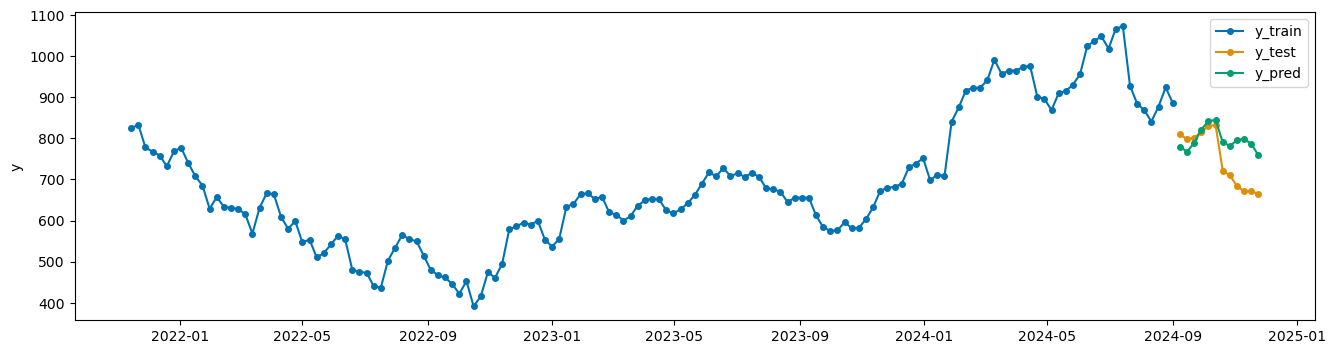

In [62]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

# Ensure ds is the index of test_data_prophet 
test_data_prophet = test_data_prophet.set_index('ds')

# Plot the forecast results
plot_series(train_data_prophet[['y']][200:], test_data_prophet[['y']], forecast, labels=["y_train", "y_test", "y_pred"]);

print()

# Now we are going to calculate the metrics of the model. The RMSE and the MAPE
mape_prophet = mean_absolute_percentage_error(test_data_prophet['y'], forecast) * 100
print("MAPE_PROPHET: ", mape_prophet)

rmse_prophet = root_mean_squared_error(test_data_prophet['y'], forecast)
print("RMSE_PROPHET: ", rmse_prophet)

The results are very positive. So, it's interesting to consider the extra information that the regressors provide. We will still try other models to see their results. All things considered, results seem to be good for now.

**XGboost**

RMSE_XGB:  93.58077334927246
MAPE_XBG:  11.287848667303148



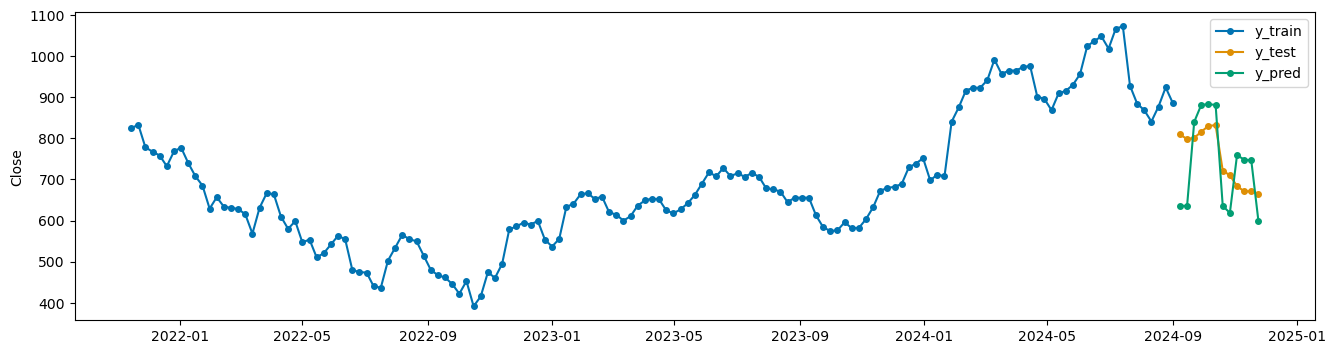

In [63]:
# We will try again XGBoost as we did in notebook 02_forecasting and we will do so using the temporal variables using the create_features function.
train_data_xgb_rf = create_features(train_data)
test_data_xgb_rf = create_features(test_data)

# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_xgb = train_data_xgb_rf.drop('Close', axis=1)
y_train_xgb = train_data_xgb_rf['Close']
X_test_xgb = test_data_xgb_rf.drop('Close', axis=1)
y_test_xgb = test_data_xgb_rf['Close']

# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

# Train the model
xgb_model.fit(X_train_xgb, y_train_xgb)

# Generate predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb = pd.DataFrame(y_pred_xgb, index=test_data.index, columns=['Close'])

# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb)
print("RMSE_XGB: ", rmse_xgb)

mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)*100
print("MAPE_XBG: ", mape_xgb)

print()

# Plot actual vs. predicted values
plot_series(y_train_xgb[200:], y_test_xgb, y_pred_xgb, labels=["y_train", "y_test", "y_pred"]);

Results if compared with the previous prophet models are not so good in a numerical and visual sense and so, we will still choose the prophet as our main model.

**Random Forest**

RMSE_RF:  88.19258759801161
MAPE_RF:  10.512349018641757



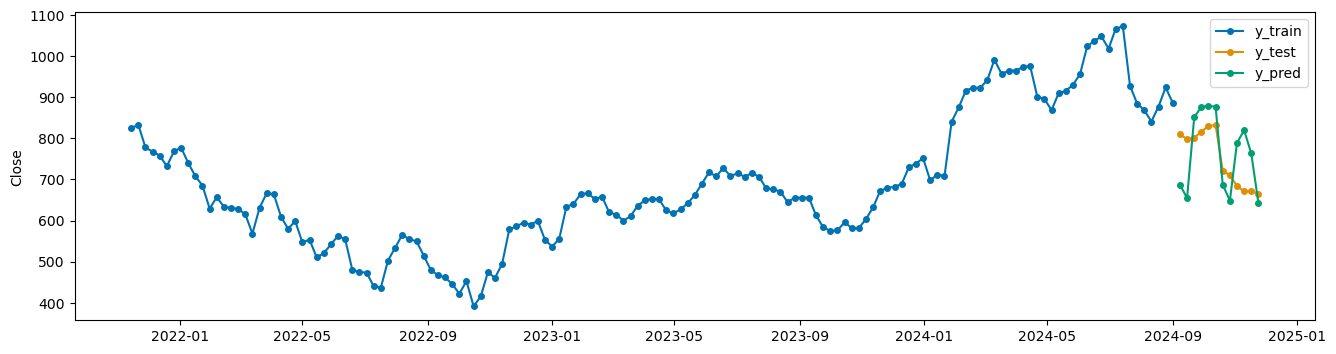

In [64]:
# We will proceed with the Random Forest model using the same logic that we used for XGBoost.
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_rf = train_data_xgb_rf.drop('Close', axis=1)
y_train_rf = train_data_xgb_rf['Close']
X_test_rf = test_data_xgb_rf.drop('Close', axis=1)
y_test_rf = test_data_xgb_rf['Close']

# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

# Train the model
rf_model.fit(X_train_rf, y_train_rf)

# Generate predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Convert predictions to a DataFrame with the same index as the test data
y_pred_rf = pd.DataFrame(y_pred_rf, index=test_data.index, columns=['Close'])

# Evaluate the model's performance
rmse_rf = root_mean_squared_error(y_test_rf, y_pred_rf)
print("RMSE_RF: ", rmse_rf)
mape_rf = mean_absolute_percentage_error(y_test_rf, y_pred_rf)*100
print("MAPE_RF: ", mape_rf)

print()

# Plot actual vs. predicted values
plot_series(y_train_rf[200:], y_test_rf, y_pred_rf, labels=["y_train", "y_test", "y_pred"]);

The results are far from convincing. So, we decide to keep with the prophet model. Nevertheless, we will create a table that compares the MAPE and RMSE results of all the models in the following code cells.

### 2.4.8 RMSE and MAPE comparison

In [65]:
# Create a dictionary to store RMSE and MAPE for each model
metrics = {
    "Model": ["SARIMAX", "Prophet", "XGBoost", "Random Forest"],
    "RMSE": [
        rmse_sarima,
        rmse_prophet,
        rmse_xgb,
        rmse_rf
    ],
    "MAPE": [
        mape_sarima,
        mape_prophet,
        mape_xgb,
        mape_rf
    ]
}

In [66]:
# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_df

,Model,RMSE,MAPE
0,SARIMAX,119.654350,13.741370
1,Prophet,72.470260,8.243324
2,XGBoost,93.580773,11.287849
3,Random Forest,88.192588,10.512349


Our best model is Prophet as it has the lowest RMSE and MAPE. We shall now proceed to do a fine-tunning of the prophet model. We will be disregarding the other models because they are significantly worse in performance.

### 3.7.3 Checking for the best regressors

Let's define the new parameters in the regressor dictionary that interests us

In [67]:
# Extracting the coefficients of the regressors from a trained Prophet model
# Ensure the prophet_model has been trained with regressors

# The model's trained parameters are stored in prophet_model.params
model_params = prophet_model.params

# Access the dataframe containing the coefficients for extra regressors
# 'beta' contains the coefficients for additional regressors
regressor_coefficients = model_params['beta'][0]

# Extract the names of the regressors
# These are stored in the model's 'extra_regressors' attribute
regressor_names = list(prophet_model.extra_regressors.keys())

# Combine the regressor names with their corresponding coefficients
# This creates a dictionary where the keys are regressor names and values are coefficients
regressor_coefficients_dict = dict(zip(regressor_names, regressor_coefficients))

# Find the top 5 regressors with the highest coefficients (absolute values)
# Sort the dictionary by absolute values of the coefficients in descending order
new_regressors = sorted(regressor_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

# Convert the top 5 regressors into a list of tuples
new_regressors_list = [regressor for regressor, coefficient in new_regressors]

# Print the top 5 regressors with the highest coefficients
print("\nTop 5 Regressors with Highest Coefficients:")
for regressor in new_regressors_list:
    print(f"{regressor}")


Top 5 Regressors with Highest Coefficients:
Close_Lam_Research_Corporation
Trade_Sanctions
New_Product_Launch
Israel_Gaza_Conflict
Tech_Regulation


Let's keep these top 5 regressors in the train_data_prophet and test_data_prophet

In [68]:
train_data_prophet = train_data_prophet[['y'] + new_regressors_list]
train_data_prophet = train_data_prophet.reset_index(names="ds")

test_data_prophet = test_data_prophet[['y'] + new_regressors_list]
test_data_prophet = test_data_prophet.reset_index(names="ds")

test_data_prophet

,ds,y,Close_Lam_Research_Corporation,Trade_Sanctions,New_Product_Launch,Israel_Gaza_Conflict,Tech_Regulation
0,2024-09-08,809.584839,73.712814,1,1,1,1
1,2024-09-15,798.271362,72.510414,1,1,1,1
2,2024-09-22,801.164551,76.603996,1,1,1,1
3,2024-09-29,816.269165,80.375000,1,1,1,1
4,2024-10-06,830.465942,81.408997,1,1,1,1
5,2024-10-13,832.022278,82.059998,1,1,1,1
6,2024-10-20,721.570862,74.139999,1,1,1,1
7,2024-10-27,710.037903,73.000000,1,1,1,1
8,2024-11-03,683.830017,75.449997,1,1,1,1
9,2024-11-10,671.159973,76.779999,1,1,1,1


### 3.7.4 Fine-tunning

Both cells for the Prophet fine-tuning code below take approximately 10 minutes each to run. Therefore, they have been commented out, and we will directly load the pickle files containing the best Prophet model for ASML from the notebook 05_modelling.

If you would like to obtain the latest results, please run the notebook 05_modelling to update the pickle files with the best Prophet model for ASML.

Note that the intention of the first code cell below is to run a code using a param_grid to gain an understanding of the approximate locations of the global minimal for ASML. 

In [69]:
# # Dictionary to store the best parameters and performance metrics
# best_params_per_company = {}
# final_mape_per_company = {}
# final_rmse_per_company = {}
# company_params = {}

# # Define parameter grid
# param_grid = {
#     "changepoint_prior_scale": [round(x, 3) for x in np.arange(0.001, 1.001, 0.1)],
#     "seasonality_prior_scale": [round(x, 2) for x in np.arange(0.01, 10.1, 1)],
#     "seasonality_mode": ['multiplicative'],
#     "weekly_seasonality": [True, False],
#     "yearly_seasonality": [True, False],
#     "daily_seasonality": [True, False]
# }

# # Create a parameter grid generator
# grid = ParameterGrid(param_grid)

# # Initialize variables to track the best parameters
# best_mape = float('inf')
# best_rmse = float('inf')
# best_params = None
# best_forecast = None

# # Perform grid search
# for params in grid:
#     try:
#         # Initialize the Prophet model with parameters from the grid
#         prophet_model = Prophet(
#             changepoint_prior_scale=params["changepoint_prior_scale"],
#             seasonality_prior_scale=params["seasonality_prior_scale"],
#             seasonality_mode=params["seasonality_mode"],
#             weekly_seasonality=params["weekly_seasonality"],
#             yearly_seasonality=params["yearly_seasonality"],
#             daily_seasonality=params["daily_seasonality"]
#         )

#         # Add new regressors
#         for regressor in new_regressors_list:
#             prophet_model.add_regressor(regressor)
        
#         # Fit the model
#         prophet_model.fit(train_data_prophet)
        
#         # Generate predictions
#         future = test_data_prophet.reset_index()[[column for column in test_data_prophet.reset_index() if column != 'y']]
#         forecast = prophet_model.predict(future)
#         forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

#         # Calculate MAPE and RMSE
#         actuals = test_data_prophet['y']
#         actuals.index = test_data_prophet['ds']
#         predictions = forecast['Close']
#         common_index = actuals.index.intersection(predictions.index)
#         mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100
#         rmse = root_mean_squared_error(actuals.loc[common_index], predictions.loc[common_index])

#         # Update the best parameters if the current MAPE is lower
#         if mape < best_mape:
#             best_mape = mape
#             best_rmse = rmse
#             best_params = params
#             best_forecast = forecast

#     except Exception as e:
#         print(f"Error with parameters: {params}: {e}")

# # Store the best parameters and performance metrics for ASML
# best_params_per_company["ASML"] = best_params
# final_mape_per_company["ASML"] = best_mape
# final_rmse_per_company["ASML"] = best_rmse
# company_params["ASML"] = best_params

# # Print the best parameters, MAPE, and RMSE
# print(f"Best parameters for ASML: {best_params}")
# print(f"MAPE: {best_mape:.2f}")
# print(f"RMSE: {best_rmse:.2f}")

# # Ensure 'ds' is the index for train and test datasets
# train_data_prophet_plot = train_data_prophet.set_index('ds')
# test_data_prophet_plot = test_data_prophet.set_index('ds')

# # Plot the forecast results for ASML
# plot_series(
#     train_data_prophet_plot['y'][-500:],  # Last 500 points of training data
#     test_data_prophet_plot['y'],
#     best_forecast['Close'],
#     labels=["y_train", "y_test", "y_pred"]
# )

# plt.title("Forecasting for ASML")
# plt.show()

Now let's run a specific param_grid for ASML
(Expected execution time 10-15 minutes)

In [70]:
# # Define ASML-specific parameters from company_params
# params = company_params["ASML"]

# # Define the parameter grid for ASML
# param_grid = {
#     'changepoint_prior_scale': np.round(
#         np.linspace(params['changepoint_prior_scale'] / 2, params['changepoint_prior_scale'] * 2, 10), 5
#     ),
#     'seasonality_prior_scale': np.round(
#         np.linspace(params['seasonality_prior_scale'] / 2, params['seasonality_prior_scale'] * 2, 10), 5
#     ),
#     'seasonality_mode': ['multiplicative'],
#     'weekly_seasonality': [True, False],
#     'yearly_seasonality': [True, False],
#     'daily_seasonality': [True, False]
# }

# # Generate all parameter combinations using ParameterGrid
# param_combinations = list(ParameterGrid(param_grid))

# # Initialize variables to track the best parameters
# best_mape = float('inf')
# best_rmse = float('inf')
# best_params = None
# best_mape_train = float('inf')
# best_rmse_train = float('inf')
# best_forecast_train = None

# # Iterate over all parameter combinations
# for combination in param_combinations:
#     try:
        
#         # Fit the Prophet model with the current parameter combination
#         model = Prophet(
#             changepoint_prior_scale=combination['changepoint_prior_scale'],
#             seasonality_prior_scale=combination['seasonality_prior_scale'],
#             seasonality_mode=combination['seasonality_mode'],
#             weekly_seasonality=combination['weekly_seasonality'],
#             yearly_seasonality=combination['yearly_seasonality'],
#             daily_seasonality=combination['daily_seasonality']
#         )
#         # Add new regressors        
#         for regressor in new_regressors_list:
#             model.add_regressor(regressor)
        
#         train_data_prophet.reset_index(drop=True, inplace=True)
            
#         # Fit the model
#         model.fit(train_data_prophet)

#         # Make predictions
#         future = test_data_prophet.reset_index()[[column for column in test_data_prophet.reset_index() if column != 'y']]
#         forecast = model.predict(future)
#         forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]
        
#         # Make predictions train
#         future_train = train_data_prophet.reset_index()[[column for column in train_data_prophet.reset_index() if column != 'y']]
#         forecast_train = model.predict(future_train)
#         forecast_train = forecast_train[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})

#         # Calculate MAPE and RMSE
#         actuals = test_data_prophet['y']
#         actuals.index = test_data_prophet['ds']
#         predictions = forecast['Close']
                
#         # Calculate MAPE and RMSE train
#         actuals_train = train_data_prophet['y']
#         actuals_train.index = train_data_prophet['ds']
#         predictions_train = forecast_train['Close']

#         common_index = actuals.index.intersection(predictions.index)
#         mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100
#         rmse = root_mean_squared_error(actuals.loc[common_index], predictions.loc[common_index])
        
#         # For train
#         common_index_train = actuals_train.index.intersection(predictions_train.index)
#         mape_train = mean_absolute_percentage_error(actuals_train.loc[common_index_train], predictions_train.loc[common_index_train]) * 100
#         rmse_train = root_mean_squared_error(actuals_train.loc[common_index_train], predictions_train.loc[common_index_train])
        
#         # Update the best parameters if the current MAPE is lower
#         if mape < best_mape:
#             best_mape = mape
#             best_rmse = rmse
#             best_params = combination            
#             best_forecast = forecast
#             best_mape_train = mape_train
#             best_rmse_train = rmse_train
#             best_forecast_train = forecast_train
                        

#     except Exception as e:
#         print(f"Error with parameters: {combination}")


# # Print the best parameters, MAPE, and RMSE for ASML
# print(f"\nBest parameters for ASML: {best_params}")
# print(f"MAPE: {best_mape:.2f}")
# print(f"RMSE: {best_rmse:.2f}")

# # Plot the forecast results for ASML
# model = Prophet(
#     changepoint_prior_scale=best_params['changepoint_prior_scale'],
#     seasonality_prior_scale=best_params['seasonality_prior_scale'],
#     seasonality_mode=best_params['seasonality_mode'],
#     weekly_seasonality=best_params['weekly_seasonality'],
#     yearly_seasonality=best_params['yearly_seasonality'],
#     daily_seasonality=best_params['daily_seasonality']
# )

# train_data_prophet.reset_index(drop=True, inplace=True)
# model.fit(train_data_prophet)

# future = model.make_future_dataframe(periods=test_weeks, freq='W')
# forecast = model.predict(future)
# forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

# # Ensure 'ds' is the index for train and test datasets
# train_data_prophet_plot = train_data_prophet.set_index('ds')
# test_data_prophet_plot = test_data_prophet.set_index('ds')

# plot_series(
#     train_data_prophet_plot['y'][-500:],  # Last 500 points of training data
#     test_data_prophet_plot['y'],
#     best_forecast['Close'],
#     labels=["y_train", "y_test", "y_pred"]
# )
# plt.title("Forecasting for ASML")
# plt.show()

**Here is the end result after loading the pickle of ASML**

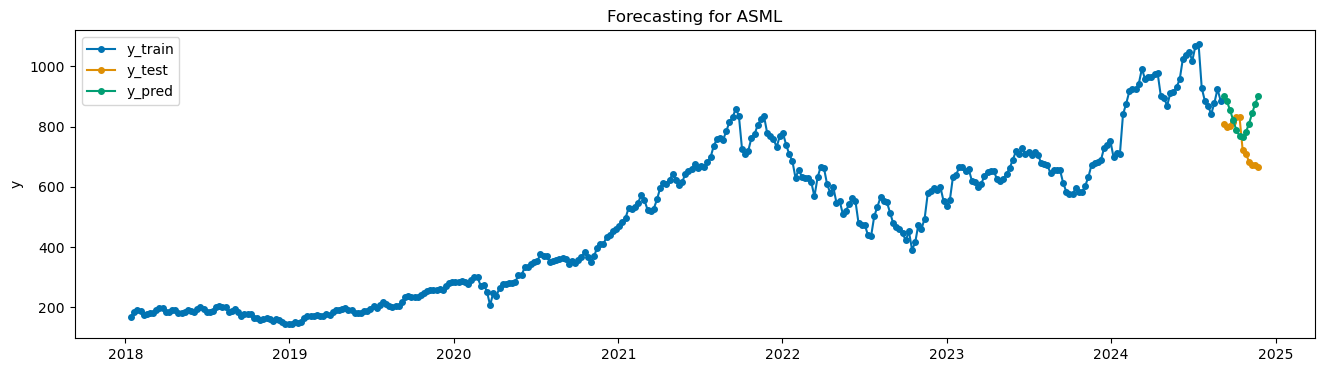

MAPE_TEST: 13.99
RMSE_TEST: 120.66
MAPE_TRAIN: 87.66
RMSE_TRAIN: 492.17


In [73]:
# Load the model from the file
model_asml_train = joblib.load(input_model_path_train)

train_data_prophet.reset_index(drop=True, inplace=True)

# Make predictions test
future = test_data_prophet.reset_index()[[column for column in test_data_prophet.reset_index() if column != 'y']]
forecast = model_asml_train.predict(future)
forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

# Ensure 'ds' is the index for train and test datasets
train_data_prophet_plot = train_data_prophet.set_index('ds')
test_data_prophet_plot = test_data_prophet.set_index('ds')

plot_series(
    train_data_prophet_plot['y'][-500:],  # Last 500 points of training data
    test_data_prophet_plot['y'],
    forecast['Close'],
    labels=["y_train", "y_test", "y_pred"]
)
plt.title("Forecasting for ASML")
plt.show()

# Make predictions train
future_train = train_data_prophet.reset_index()[[column for column in train_data_prophet.reset_index() if column != 'y']]
forecast_train = model.predict(future_train)
forecast_train = forecast_train[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})

# Calculate MAPE and RMSE test
actuals = test_data_prophet['y']
actuals.index = test_data_prophet['ds']
predictions = forecast['Close']

common_index = actuals.index.intersection(predictions.index)
mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100
rmse = root_mean_squared_error(actuals.loc[common_index], predictions.loc[common_index])

print(f"MAPE_TEST: {mape:.2f}")
print(f"RMSE_TEST: {rmse:.2f}")

# Calculate MAPE and RMSE train
actuals_train = train_data_prophet['y']
actuals_train.index = train_data_prophet['ds']
predictions_train = forecast_train['Close']

common_index_train = actuals_train.index.intersection(predictions_train.index)
mape_train = mean_absolute_percentage_error(actuals_train.loc[common_index_train], predictions_train.loc[common_index_train]) * 100
rmse_train = root_mean_squared_error(actuals_train.loc[common_index_train], predictions_train.loc[common_index_train])

print(f"MAPE_TRAIN: {mape_train:.2f}")
print(f"RMSE_TRAIN: {rmse_train:.2f}")

In [75]:
forecast

,Close
2024-09-08,900.911444
2024-09-15,883.087213
2024-09-22,854.506245
2024-09-29,820.092848
2024-10-06,788.488949
2024-10-13,768.532222
2024-10-20,765.748635
2024-10-27,780.660079
2024-11-03,809.045590
2024-11-10,843.525146


### 3.7.5 Checking for Overfitting

Looking at the MAPE and RMSE values of the test and train dataframes, there is overfitting as is visible because we are working with a time series model and it's normal. Nevertheless, it is not a very big overfitting.

### 3.7.6 Results

The final fine-tune prophet model improved the MAPE and the RMSE results with respect to the non-fine tunned prophet model

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

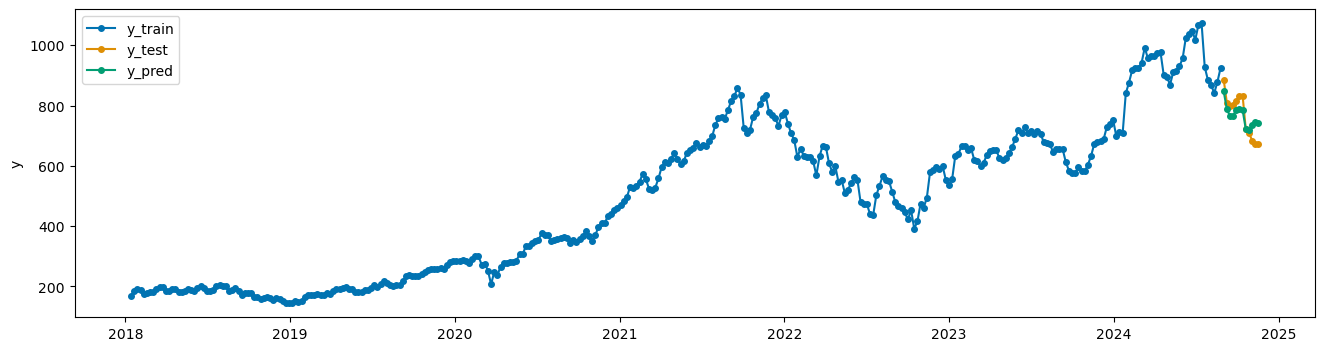

In [58]:
plot_series(
    train_data_prophet_plot['y'][-500:],  # Last 500 points of training data
    test_data_prophet_plot['y'],
    best_forecast['Close'],
    labels=["y_train", "y_test", "y_pred"]
)

## 3.8 Model Comparison

For a complete exploratory analysis of the model comparison between the baseline prophet model of notebook 02_forecasting and the prophet model of asml with exogenous variables and asml supplier stocks of notebook 05_modelling, please refer to notebook [Go to Notebook 06_model_comparison.ipynb](06_model_comparison.ipynb)

### 3.8.1 Train test split

We are going to consider *test_weeks* as the number of weeks we want the test to have

In [7]:
train_data = weekly_data_combination[:-test_weeks]
train_data.head()

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Close_Applied_Materials,Close_MKS_Instruments,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,,,
2018-01-14,168.662338,60.946632,10.968469,32.766666,49.413509,91.228027,0,0,0,0,0,0
2018-01-21,185.736526,60.851780,11.747066,34.386667,53.037470,98.577488,0,0,0,0,0,0
2018-01-28,191.564713,61.373493,11.971690,34.026669,52.806355,99.857712,0,0,0,0,0,0
2018-02-04,187.825333,61.335556,10.935276,31.420000,49.348789,97.202438,0,0,0,0,0,0
2018-02-11,174.080200,58.831284,9.748922,28.526667,44.661667,98.150764,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-28,884.676086,66.550003,90.711090,94.610001,206.134949,124.344772,0,1,1,1,1,1
2024-08-04,868.516907,68.070000,85.226768,92.120003,196.363693,119.044373,0,1,1,1,1,1
2024-08-11,841.041199,68.430000,76.805382,86.529999,182.959366,106.227585,0,1,1,1,1,1


In [8]:
test_data = weekly_data_combination[-test_weeks:]
test_data.head()

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Close_Applied_Materials,Close_MKS_Instruments,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,,,
2024-09-01,886.055847,72.644997,81.642670,89.629997,195.770004,117.970001,0,1,1,1,1,1
2024-09-08,809.584839,66.605000,75.787483,79.215000,181.310005,107.970001,0,1,1,1,1,1
2024-09-15,798.271362,63.835999,74.551239,82.000000,183.210007,107.849998,0,1,1,1,1,1
2024-09-22,801.164551,65.324997,76.603996,83.349998,188.589996,109.099998,0,1,1,1,1,1
2024-09-29,816.269165,70.800003,80.375000,85.470001,197.309998,109.449997,0,1,1,1,1,1


### 3.8.2 Doing predictions using the prophet pickle models 

In [9]:
# Prepare the train data for prediction
# Prophet requires a 'ds' column with dates and 'y' column with values to predict
train_data = train_data.rename(columns={'Date': 'ds', 'Close_ASML': 'y'})  # Rename
train_data = train_data.reset_index(names="ds")  # Reset index to ensure 'ds' is a column

# Prepare the test data for prediction
# Prophet requires a 'ds' column with dates and 'y' column with values to predict
test_data = test_data.rename(columns={'Date': 'ds', 'Close_ASML': 'y'})  # Rename 
test_data = test_data.reset_index(names="ds")  # Reset index to ensure 'ds' is a column

# Forecasting with the prophet_model_best_asml pickle
forecast_model_asml = prophet_model_best_asml.predict(test_data[[column for column in test_data if column != 'y']])

# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_model_asml = forecast_model_asml[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

# Forecasting with the prophet_model_best_asml_suppliers pickle
# Generate predictions
forecast_model_asml_suppliers = prophet_model_best_asml_suppliers.predict(test_data[[column for column in test_data if column != 'y']])

# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_model_asml_suppliers = forecast_model_asml_suppliers[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

,ds,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Close_Applied_Materials,Close_MKS_Instruments,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
0,2018-01-14,168.662338,60.946632,10.968469,32.766666,49.413509,91.228027,0,0,0,0,0,0
1,2018-01-21,185.736526,60.851780,11.747066,34.386667,53.037470,98.577488,0,0,0,0,0,0
2,2018-01-28,191.564713,61.373493,11.971690,34.026669,52.806355,99.857712,0,0,0,0,0,0
3,2018-02-04,187.825333,61.335556,10.935276,31.420000,49.348789,97.202438,0,0,0,0,0,0
4,2018-02-11,174.080200,58.831284,9.748922,28.526667,44.661667,98.150764,0,0,0,0,0,0


### 3.8.3 Comparison of both models

Setting column 'ds' as the indexes of train_data and test_data

In [15]:
# Setting column 'ds' as the indexes of train_data and test_data
# Step 1: Set 'ds' as the index for train_data
train_data = train_data.set_index('ds')

# Step 1: Set 'ds' as the index for test_data
test_data = test_data.set_index('ds')

,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Close_Applied_Materials,Close_MKS_Instruments,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
ds,,,,,,,,,,,,
2018-01-14,168.662338,60.946632,10.968469,32.766666,49.413509,91.228027,0,0,0,0,0,0
2018-01-21,185.736526,60.851780,11.747066,34.386667,53.037470,98.577488,0,0,0,0,0,0
2018-01-28,191.564713,61.373493,11.971690,34.026669,52.806355,99.857712,0,0,0,0,0,0
2018-02-04,187.825333,61.335556,10.935276,31.420000,49.348789,97.202438,0,0,0,0,0,0
2018-02-11,174.080200,58.831284,9.748922,28.526667,44.661667,98.150764,0,0,0,0,0,0


### 3.8.4 Plotting both graphs

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

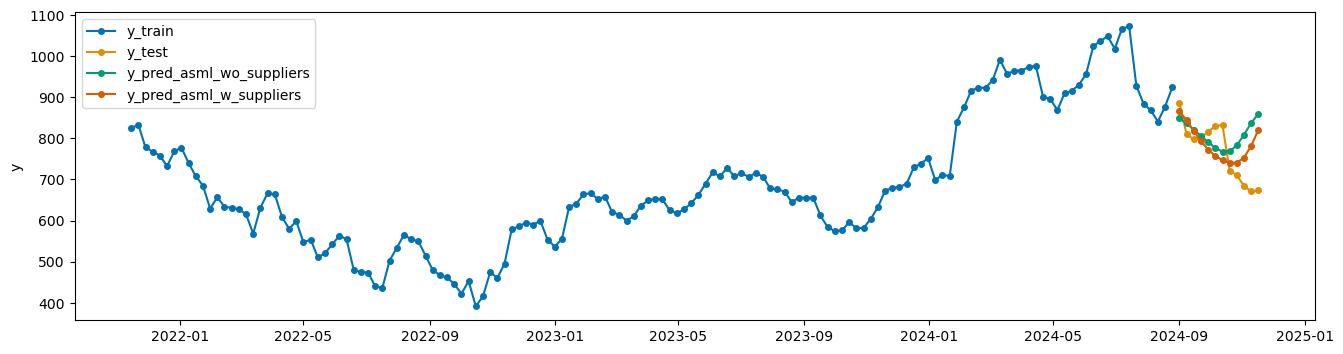

In [19]:
# Plot the series with train, test, and predictions from both models
plot_series(
    train_data['y'][200:],          # Training data starting from index 500 for better visualization
    test_data['y'],                 # Test data for comparison
    forecast_model_asml,            # Predictions from the ASML model
    forecast_model_asml_suppliers,  # Predictions from the ASML suppliers model
    labels=["y_train", "y_test", "y_pred_asml_wo_suppliers", "y_pred_asml_w_suppliers"]  # Labels for each line in the plot
)

### 3.8.5 Comparing metrics

MAPE and RMSE of the model forecast_model_asml (without supplier/exogenous data)

In [20]:
print("MAPE:", best_prophet_variables_asml['mape_prophet_best'])
print()
print("RMSE:", best_prophet_variables_asml['rmse_prophet_best'])

MAPE: 9.658131513091737

RMSE: 89.46018922218984


MAPE and RMSE of the model forecast_model_asml_suppliers (with supplier/exogenous data)

In [21]:
print("MAPE:", best_prophet_variables_asml_suppliers['mape_prophet_best_with_suppliers'])
print()
print("RMSE:", best_prophet_variables_asml_suppliers['rmse_prophet_best_with_suppliers'])

MAPE: 5.037144408402684

RMSE: 43.398696214667545


### 3.8.6 Conclusions

In comparing the best_prophet_variables_asml model (without supplier/exogenous data) with the best_prophet_variables_asml_suppliers model (including supplier/exogenous data), several key insights emerged:

1. Model Performance: The inclusion of supplier and exogenous variables in best_prophet_variables_asml_suppliers resulted in improved accuracy, as indicated by lower MAPE and RMSE values compared to best_prophet_variables_asml. This demonstrates that incorporating relevant external variables can enhance the predictive capabilities of the model.

2. Predictive Value of Exogenous Variables: The addition of supplier-specific data provided valuable context, likely capturing market dynamics and trends that affect ASML's stock price. This indicates that external factors, including supplier performance and geopolitical events, have a meaningful impact on ASML's future performance.

3. Practical Implications: The enhanced model (best_prophet_variables_asml_suppliers) is more robust and can potentially inform better strategic decisions by providing more accurate predictions. This model may be especially useful in scenarios where external market conditions are volatile, allowing for more adaptive planning and risk management.

## 3.9 Future predictions

For a complete exploratory analysis of the prediction of ASML stock into the future, please refer to notebook [Go to Notebook 07_future_predictions.ipynb](07_future_predictions.ipynb)

In [7]:
# Create an empty dictionary to store the loaded models
models_suppliers = {}

# Iterate over each supplier in company_tickers to load its model
for company in regressors:
    if 'Close' in company:
        company = company.replace('Close_', '')
        # Define the file path to the model pickle file for the current supplier
        model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'
        
        # Load the model and store it in the dictionary using the supplier's name
        models_suppliers[company] = joblib.load(model_path)
        print(f'Prophet model for {company} loaded from {model_path}')

Prophet model for Lam_Research_Corporation loaded from models/prophet_asml_supplier_Lam_Research_Corporation.pkl
Prophet model for Carl_Zeiss_Meditec loaded from models/prophet_asml_supplier_Carl_Zeiss_Meditec.pkl


### 3.9.1 Train the model with new data

The prophet model that was trained in notebook 05_modelling, we are going to train it again with all the data without separating between train and test. 

In [8]:
# Initialize the Prophet model with the loaded best parameters
prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    daily_seasonality=best_params['daily_seasonality'],
    seasonality_mode=best_params['seasonality_mode'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    weekly_seasonality=best_params['weekly_seasonality'],
    yearly_seasonality=best_params['yearly_seasonality']
)

Modify the column names as required by prophet

In [9]:
train_data = weekly_data_combination.reset_index(names="ds").rename(columns={'Close_ASML':'y'})

Add regressors

In [10]:
for regressor in regressors:
    prophet_model.add_regressor(regressor)

Fit the model

In [11]:
prophet_model.fit(train_data)

21:56:01 - cmdstanpy - INFO - Chain [1] start processing
21:56:01 - cmdstanpy - INFO - Chain [1] done processing


### 3.9.2 Building the future dataframe 

In [ ]:
future_dataframe = prophet_model.make_future_dataframe(periods=future_weeks, freq='w')[-future_weeks:]
future_dataframe

Predict the stock of ASML's suppliers using the prophet models of the suppliers that were done in notebook 03_selecting_asml_suppliers

In [12]:
# Iterate over each supplier in company_tickers to make predictions
for company in regressors:
    if 'Close' in company:
        company = company.replace('Close_', '')
        
        # Get the loaded Prophet model for the current supplier from the models_suppliers dictionary
        model = models_suppliers[company]

        # Generate predictions on the future_dataframe using the model
        forecast = model.predict(future_dataframe)

        # Select only 'ds' and 'yhat' columns, rename 'yhat' to 'Close_{company}'
        forecast = forecast[['ds', 'yhat']].rename(columns={'yhat': f'Close_{company.replace(" ", "_")}'})

        # Merge the forecast data with the future_dataframe on the 'ds' column
        future_dataframe = future_dataframe.merge(forecast, on='ds', how='left')

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  dates = pd.date_range(


,ds
358,2024-11-24
359,2024-12-01


Predict the stock of ASML's suppliers using the prophet models of the suppliers that were done in notebook 03_selecting_asml_suppliers

In [13]:
# Iterate over each supplier in company_tickers to make predictions
for company in regressors:
    if 'Close' in company:
        company = company.replace('Close_', '')
        
        # Get the loaded Prophet model for the current supplier from the models_suppliers dictionary
        model = models_suppliers[company]

        # Generate predictions on the future_dataframe using the model
        forecast = model.predict(future_dataframe)

        # Select only 'ds' and 'yhat' columns, rename 'yhat' to 'Close_{company}'
        forecast = forecast[['ds', 'yhat']].rename(columns={'yhat': f'Close_{company.replace(" ", "_")}'})

        # Merge the forecast data with the future_dataframe on the 'ds' column
        future_dataframe = future_dataframe.merge(forecast, on='ds', how='left')

In [14]:
future_dataframe

,ds,Close_Lam_Research_Corporation,Close_Carl_Zeiss_Meditec
0,2024-11-24,72.487447,64.618490
1,2024-12-01,72.706585,64.754366


Let's predict the exogenous variables into the future and add them to the future_dataframe as well 

In [15]:
# Apply the function to future_dataframe
add_exogenous_variables(future_dataframe, regressors)

future_dataframe

,ds,Close_Lam_Research_Corporation,Close_Carl_Zeiss_Meditec,New_Product_Launch,COVID_Period,Trade_Sanctions
0,2024-11-24,72.487447,64.618490,1,0,1
1,2024-12-01,72.706585,64.754366,1,0,1


### 2.4.7 Predicting the stock values of ASML 

In [16]:
# Generate predictions
future_dataframe_ASML_stock = prophet_model.predict(future_dataframe)

# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
future_dataframe_ASML_stock = future_dataframe_ASML_stock[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})

future_dataframe_ASML_stock

,Close
ds,
2024-11-24,735.105514
2024-12-01,739.989446


Let's do a representation of the results

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Close_ASML'>)

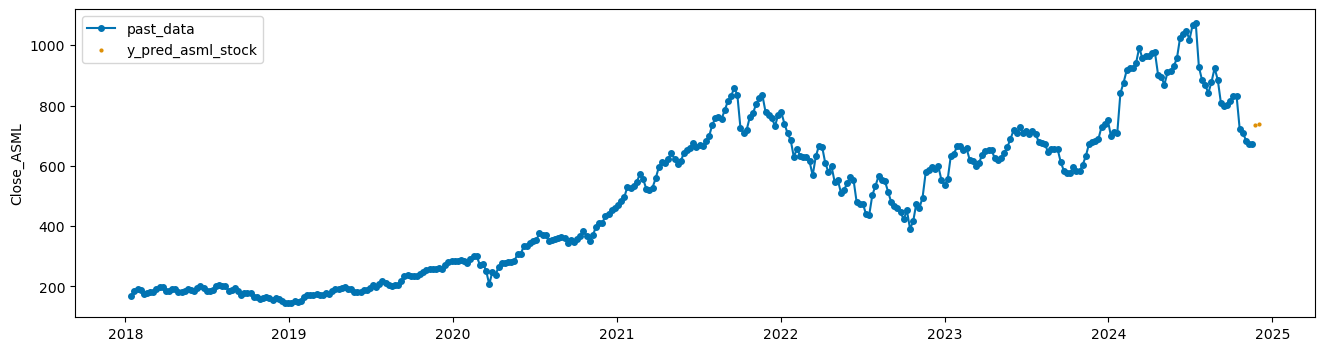

In [17]:
# Plot the series with train, test, and predictions from both models
plot_series(
    weekly_data_combination['Close_ASML'],             # Training data starting from index 500 for better visualization
    future_dataframe_ASML_stock,                       # Predictions from the ASML model
    labels=["past_data", "y_pred_asml_stock"]          # Labels for each line in the plot
)

aa